In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/CHIP_vars'

RB1060  
117875465	117875465	A	C	exonic	RAD21	nonsynonymous SNV  
117869732	117869732	T	C	intronic	RAD21	NA  
106197631	106197631	A	C	exonic	TET2	synonymous SNV  
31023741	31023741	A	T	exonic	ASXL1	nonsynonymous SNV  


RB1003  
25457243	25457243	G	A	exonic	DNMT3A	nonsynonymous SNV  
25462022	25462022	C	T	exonic	DNMT3A	stopgain  
25463541	25463541	G	C	exonic	DNMT3A	nonsynonymous SNV  
25464501	25464501	G	C	exonic	DNMT3A	nonsynonymous SNV  
43814926	43814926	T	A	intronic	MPL	NA  
119149239	119149239	G	C	exonic	CBL	nonsynonymous SNV  
148512211	148512211	T	C	intronic	EZH2	NA  


In [2]:
#config_f = "config.yaml"
outdir=""

frag_indir = "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/CHIP_dec172021_b1/MTBlacklist_A2/"
samples = "Control,Flt3l,Input"
chip_genes = "DNMT3A,MPL,CBL,EZH2,RAD21,TET2,ASXL1,TP53,U2AF1,SF3B1,SRSF2,IDH1,IDH2"
is_chip_nameerror = False
cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/cells_meta.tsv"
clones_meta_f = '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/results/clones_summary/feb23_2022/clones_summary.csv'

outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/chip_markers"

In [3]:
# cells_meta_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/cells_meta.tsv" 
# se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/annotation/gff_hg38_1_2/mergedSamples/allSamples.integrated.rds" 
# outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones"

In [4]:
chip_genes = chip_genes.split(",")
samples = samples.split(",")

samples_dict = {ind+1: val for ind, val in enumerate(samples)}

In [5]:
if is_chip_nameerror:
    single_cell_dirs = {"Flt3l":"Control", "Control":"Flt3l", "Input":"Input"}
else:
    single_cell_dirs = {s:s for s in samples}


In [6]:
samples

['Control', 'Flt3l', 'Input']

In [7]:
import os
if outdir == "":
    outdir="./output"

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [8]:
from src.utils.parse_config import read_config_file
from os.path import join, dirname
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mplh.cluster_help as ch
%load_ext autoreload
%autoreload 2

%matplotlib inline

fig_utils from mplh
here


## Load clone meta and cell IDs

In [9]:
from os.path import basename

In [10]:
dendro_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/barcodes/btwnClones/donor*dendro.csv"

dendro_fs = glob(dendro_indir)
clones_meta = []
for f in dendro_fs:
    clones_meta.append(pd.read_csv(f))
    clones_meta[-1]["den_clust"] = clones_meta[-1]["den_clust"] + f"_{basename(f).split('.dendro')[0]}"
clones_meta = pd.concat(clones_meta, axis=0)

clones_meta.index = clones_meta["donor"].astype(str)+"_"+clones_meta["lineage"].astype(str)


#clones_meta = pd.read_csv(clones_meta_f, index_col=0)
#clones_meta

In [11]:
cells_meta = pd.read_csv(cells_meta_f, sep="\t", index_col=0)
cells_meta["name"] = cells_meta["donor"].astype(str) + "_" + cells_meta["lineage"].astype(str) + "_" + cells_meta["condition"]
cells_meta["ID"] = cells_meta["donor"].astype(str) + "_" + cells_meta["lineage"].astype(str) 
cells_meta["fold_change"] = cells_meta["ID"].map(clones_meta["fold_change"])

cells_meta


cells_meta["den_clust"] = cells_meta["ID"].map(clones_meta["den_clust"])


In [12]:
#config = read_config_file(config_f)
#chip_genes = config["chip_genes"]
#config


In [13]:
def peaks_gene(df, gene, anno):
    inds = anno[anno["gene"]==gene].index
    df = df.loc[df.index.isin(inds)]
    anno=anno.loc[anno.index.isin(inds)]
    return df, anno

In [14]:
def filt_cells(df, cells):
    df = df.loc[:, df.columns.isin(cells.index)]
    cells = cells.loc[df.columns]
    return df, cells

In [15]:
def clone_mean(curr_clone, peaks_dense, method="mean"):
    if method == "mean":
        return peaks_dense.loc[:, peaks_dense.columns.isin(curr_clone.index)].mean(axis=1)
    elif method == "median":
        return peaks_dense.loc[:, peaks_dense.columns.isin(curr_clone.index)].median(axis=1)
    
def get_clone(name, meta):
    curr = meta.loc["_".join(name.split("_")[:2])]
    #print('curr', curr)
    curr.name=name
    curr.loc["condition"] = name.split("_")[2]
    return curr


## Create peak matrix for each connditionn

## Functions for plotting

In [16]:
col_clr_schemes = {c:"categorical" for c in ["donor", "condition", "fold_change", "den_clust"]}
col_clr_schemes["ncells"] = "sequential"


In [17]:
def clones_plot(peaks_df, clones_meta, cells_anno, name, gene_name):
    clones_peaks_dense = cells_anno.groupby("name").apply(clone_mean, peaks_df).fillna(0).transpose()
    clones_peaks_dense.head()

    clones_peaks_median_dense = cells_anno.groupby("name").apply(clone_mean, peaks_df, "median").fillna(0).transpose()
    clones_peaks_median_dense.head()
    
    # Convert the clone_condition to clone
    curr_clone_meta = pd.DataFrame([get_clone(x, clones_meta) for x in clones_peaks_dense.columns])
    curr_clone_meta.head()

    g = ch.plot_cluster(clones_peaks_dense.fillna(0), 
                        row_meta=chip_anno.loc[clones_peaks_dense.index,["gene", "peak_type"]], 
                        col_clr_schemes=col_clr_schemes,
                        col_meta=curr_clone_meta[col_clr_schemes.keys()].astype(str),
                        to_row_clust=True, sep_clr_map=True, to_col_clust=True,
                        metric='jaccard', to_legend=True, white_name=None, row_names=False )

    g.fig.suptitle(name+" mean")
    plt.savefig(join(outdir, f"{name}_cloneMean_{gene_name}_chromatinFragments.png"), bbox_inches='tight')
   
    # 2b median of chip 
    g = ch.plot_cluster(clones_peaks_median_dense.fillna(0), 
                        row_meta=chip_anno.loc[clones_peaks_median_dense.index, ["gene", "peak_type"]], 
                        col_clr_schemes=col_clr_schemes,
                        col_meta=curr_clone_meta[col_clr_schemes.keys()].astype(str),
                        to_row_clust=True, sep_clr_map=True, to_col_clust=True,
                        metric='jaccard', to_legend=True, white_name=None, row_names=False )
    g.fig.suptitle(name+" median")
    plt.savefig(join(outdir, f"{name}_cloneMedian_{gene_name}_chromatinFragments.png"), bbox_inches='tight')
   
    return


In [18]:
def dendro_plots(peaks_df, cells_anno, name, gene_name):
    # 3. Get dendro mean and median for chip   
    dend_peaks_dense = cells_anno.groupby("den_clust").apply(clone_mean, peaks_df).fillna(0).transpose()
    dend_peaks_median_dense = cells_anno.groupby("den_clust").apply(clone_mean, peaks_df, "median").fillna(0).transpose()

    # 3a. mean
    g = ch.plot_cluster(dend_peaks_dense.fillna(0), 
                        row_meta=chip_anno.loc[dend_peaks_dense.index, ["gene", "peak_type"]], 
                        to_row_clust=True, sep_clr_map=True, to_col_clust=False,
                        metric='jaccard', to_legend=True, white_name=None, row_names=False )
  
    g.fig.suptitle(name+" CHIP (mean in dendro)")
    plt.savefig(join(outdir, f"{name}_dendroMean_{gene_name}_chromatinFragments.png"), bbox_inches='tight')
    
    # 3b. median
    g = ch.plot_cluster(dend_peaks_median_dense.fillna(0), 
                        row_meta=chip_anno.loc[dend_peaks_median_dense.index, ["gene", "peak_type"]], 
                        to_row_clust=True, sep_clr_map=True, to_col_clust=False,
                        metric='jaccard', to_legend=True, white_name=None, row_names=False )

    g.fig.suptitle(name+" CHIP (median in dendro cluster)")
    plt.savefig(join(outdir, f"{name}_dendroMedian_{gene_name}_chromatinFragments.png"), bbox_inches='tight')

    return

In [19]:

def wrap_plots(peaks_df, peaks_anno, cells_anno, name, gene_name, clones_meta):
    # 1. Cluster cells by peaks 
    # Filter for peaks in the anno and vice versa
    peaks_df, cells_anno = filt_cells(peaks_df, cells_anno) #cells_anno.loc[cells_anno.index.isin(dnmt3.columns)]
    
    g = ch.plot_cluster(peaks_df.fillna(0), row_meta=chip_anno.loc[peaks_df.index,["gene", "peak_type"]], 
                    col_meta=cells_anno[["donor", "condition", "fold_change", "den_clust"]].astype(str),
                    to_row_clust=True, 
                    metric='jaccard', to_legend=True, white_name=None, row_names=False )
    g.fig.suptitle(name)
    plt.savefig(join(outdir, f"{name}_{gene_name}_genes_chromatinFragments.png"), bbox_inches='tight')

    
    ### clone meta for each condition
    clones_plot(peaks_df, clones_meta, cells_anno, name, gene_name)

    dendro_plots(peaks_df, cells_anno, name, gene_name)
    
    return

In [20]:
def process_frag_indir(frag_indir, s):
    curr_in = join(frag_indir, s, "outs")

    CBs = pd.read_csv(join(frag_indir, single_cell_dirs[s], "outs", "singlecell.csv"))
    CBs = CBs.loc[CBs["barcode"]!= "NO_BARCODE"].reset_index() ## drop the 'NO_BARCODE'
    CBs.index= CBs.index+1
    CBs["Condition ID"] = CBs["barcode"].apply(lambda x: x.split("-")[-1])
    CBs["Condition"] = CBs["Condition ID"].astype(int).map(samples_dict)
      
    cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)
    ## Load peak annotations

    peak_annotations = pd.read_csv(join(curr_in,'peak_annotation.tsv'),sep='\t')
    peak_annotations.index=peak_annotations.index+1
    peak_annotations["gene"] = peak_annotations["gene"].str.upper()
    peak_annotations["Peak"] = peak_annotations.index
    ## Filter for the chip genes 
    ## Uses peak_annotations
    # Load peaks matrix
    filename = join(curr_in,'filtered_peak_bc_matrix/matrix.mtx')
    peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=3, header=None)
    peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]

    chip_anno = peak_annotations[peak_annotations["gene"].isin(chip_genes)].set_index("Peak", drop=True).copy()
    chip_anno.head()

    peaks_sparse_mtx = peaks_sparse_mtx.loc[peaks_sparse_mtx["Peak"].isin(chip_anno.index)]
    peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].map(peak_annotations["gene"])
    CBs["barcode"] = CBs.loc[:,"barcode"] + "_" + s
    peaks_sparse_mtx.loc[:, "Cell"] = peaks_sparse_mtx["Cell"].map(CBs['barcode'])
    
    peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)
    CBs = CBs.set_index("barcode")
    chip_anno["ID"] = chip_anno.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
    chip_peaks_dense = peaks_dense.loc[peaks_dense.index.isin(chip_anno.index)].copy()    

    return peaks_dense, CBs, chip_peaks_dense, chip_anno

Control


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Flt3l


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Input


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

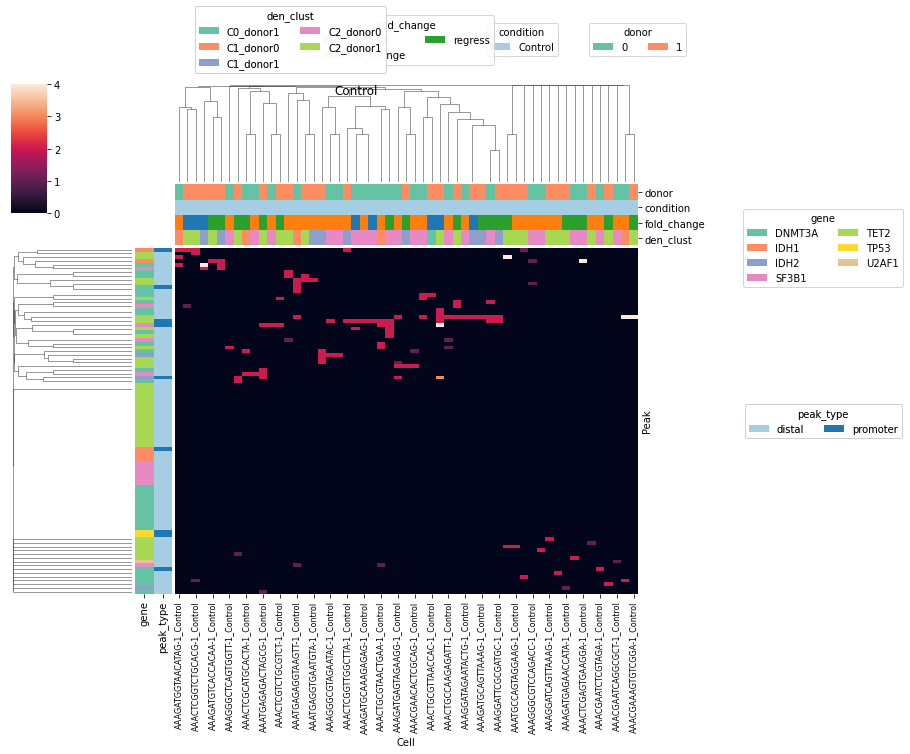

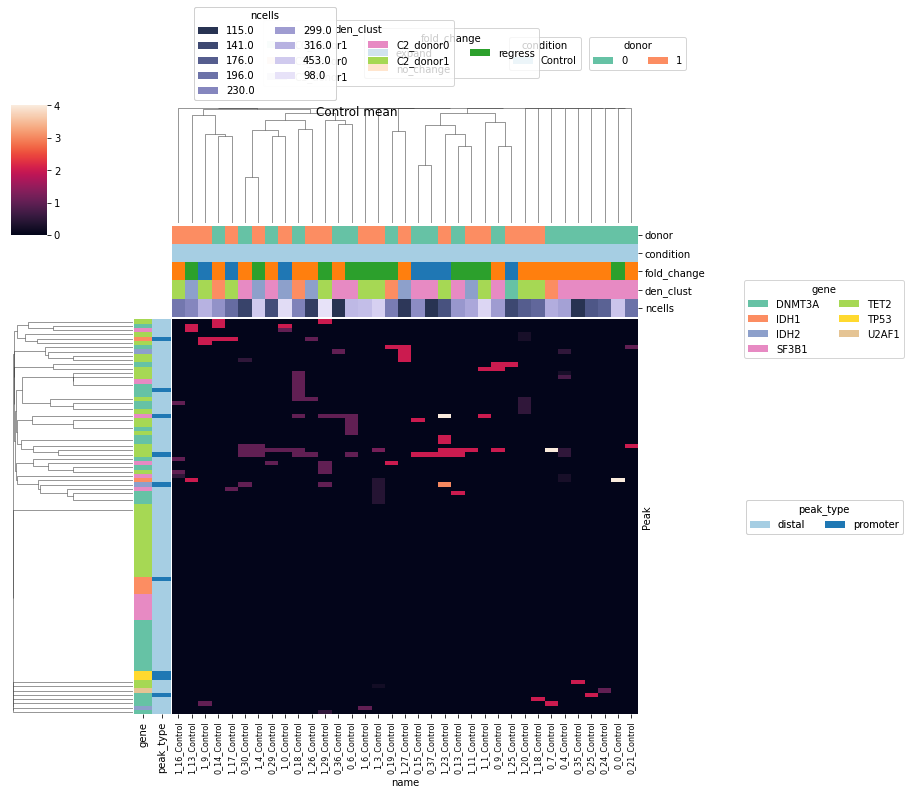

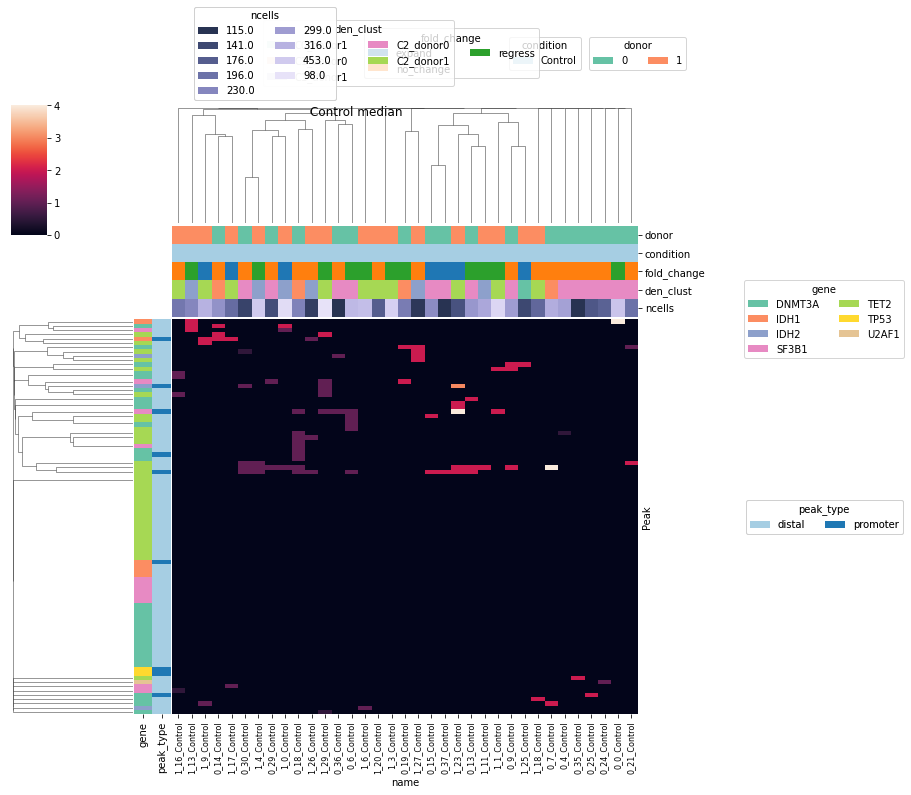

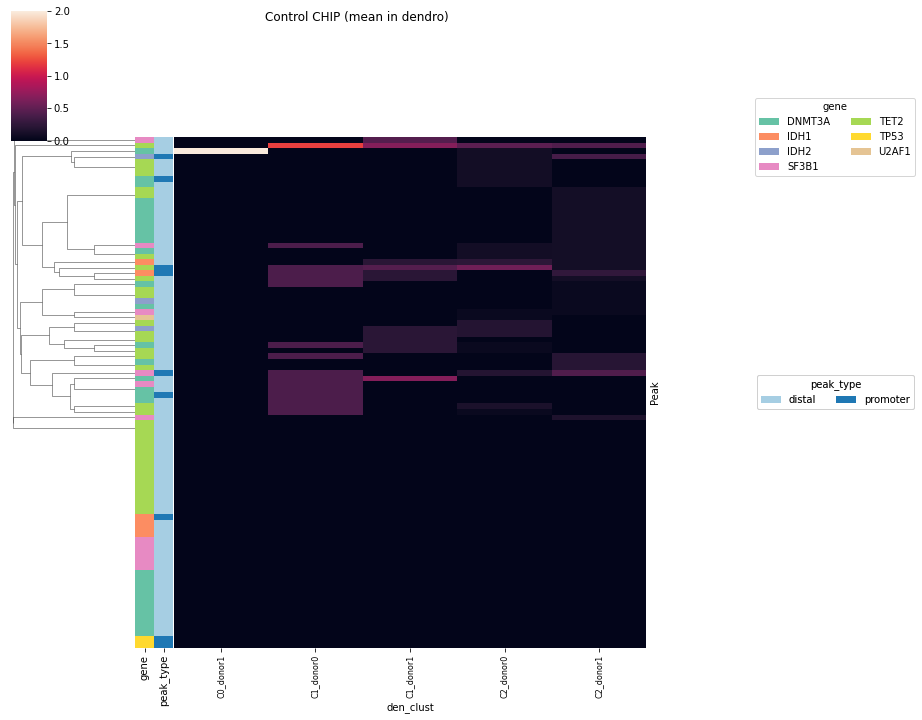

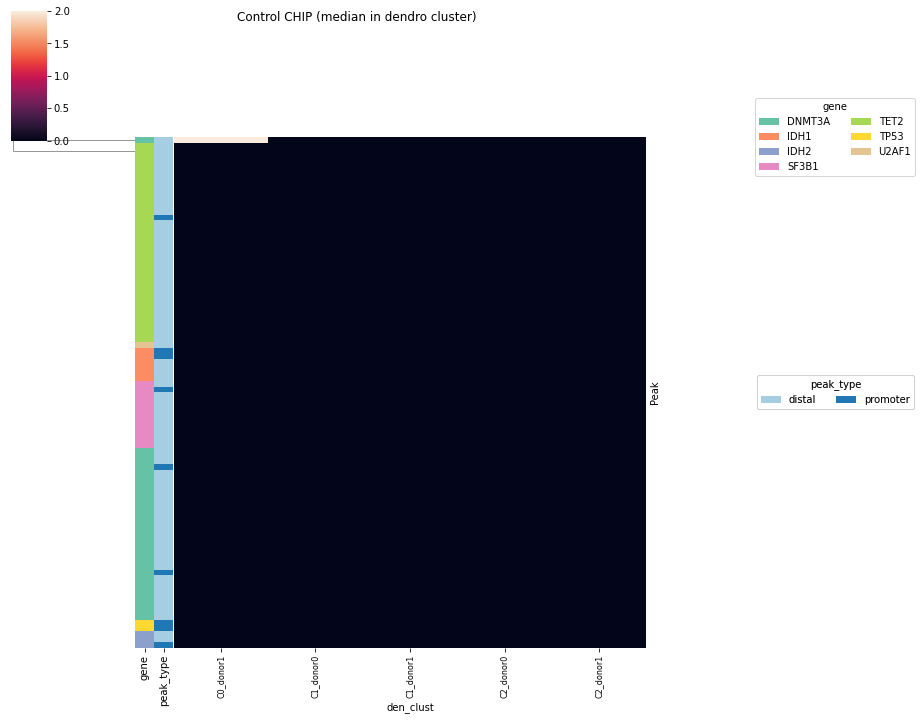

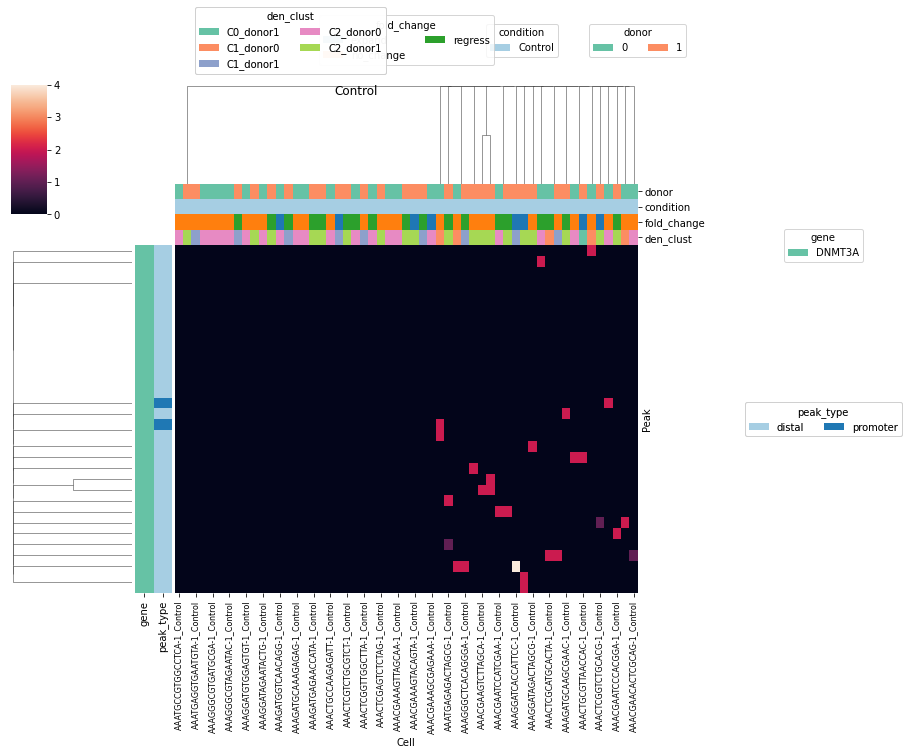

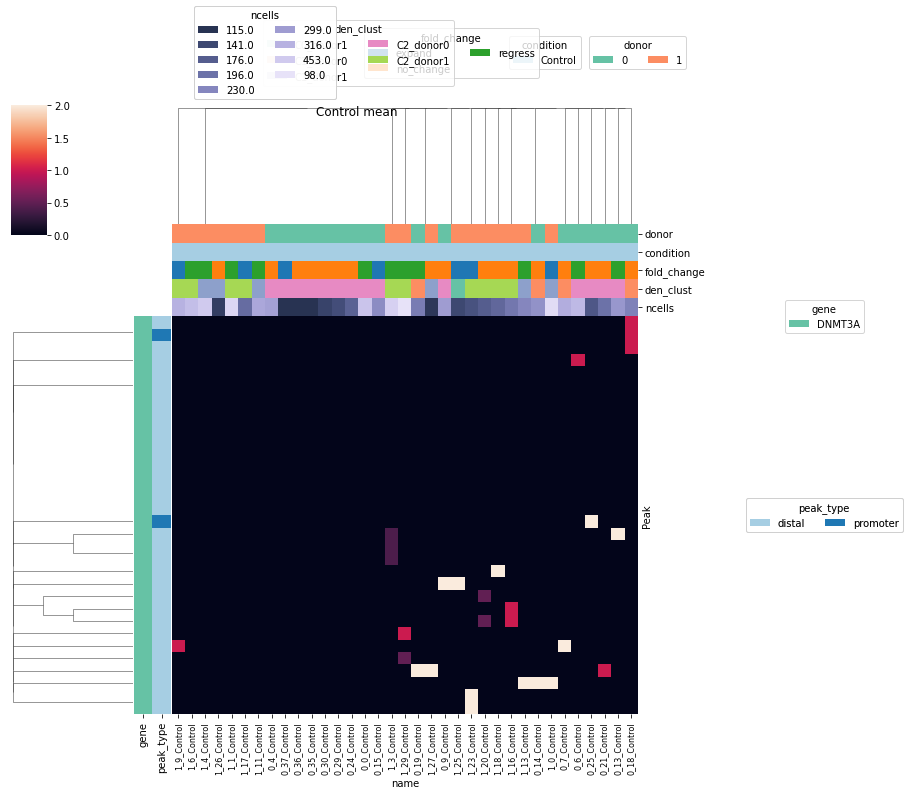

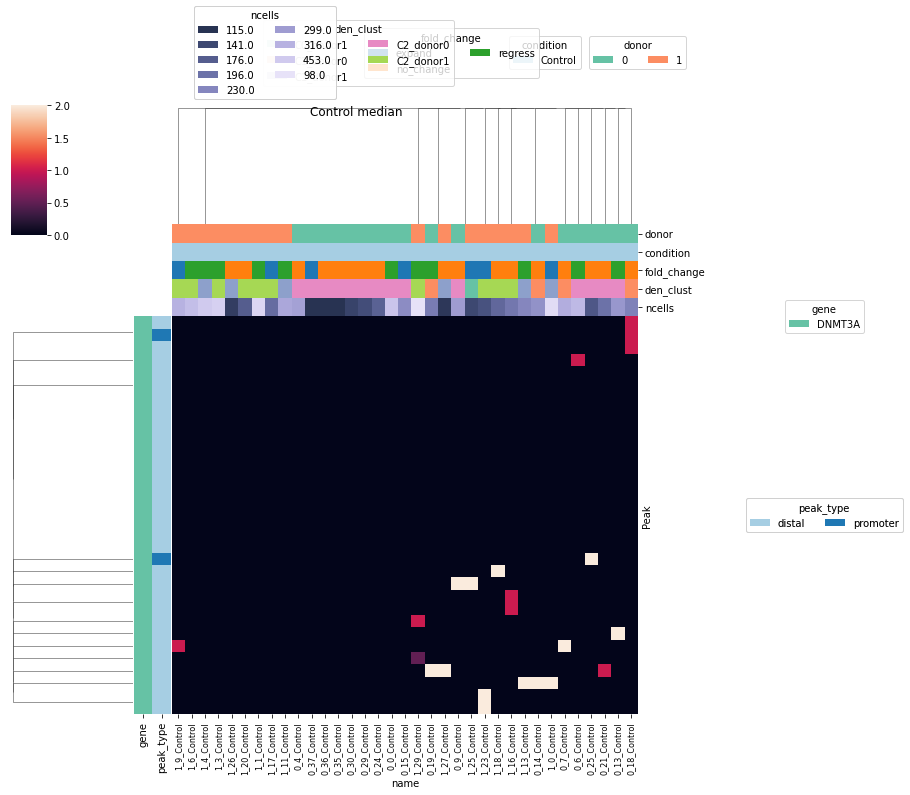

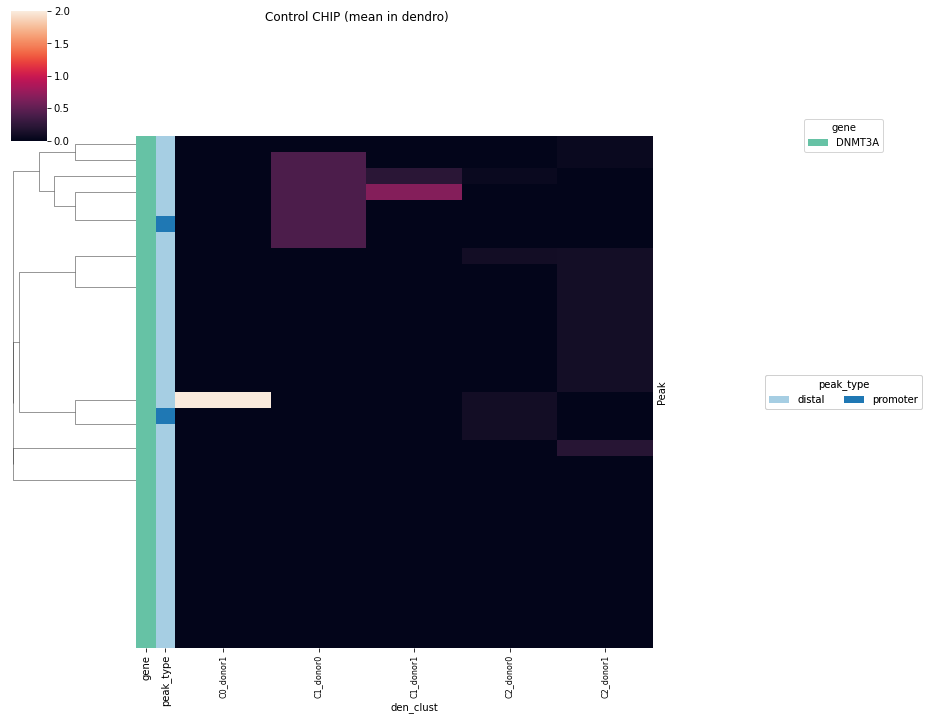

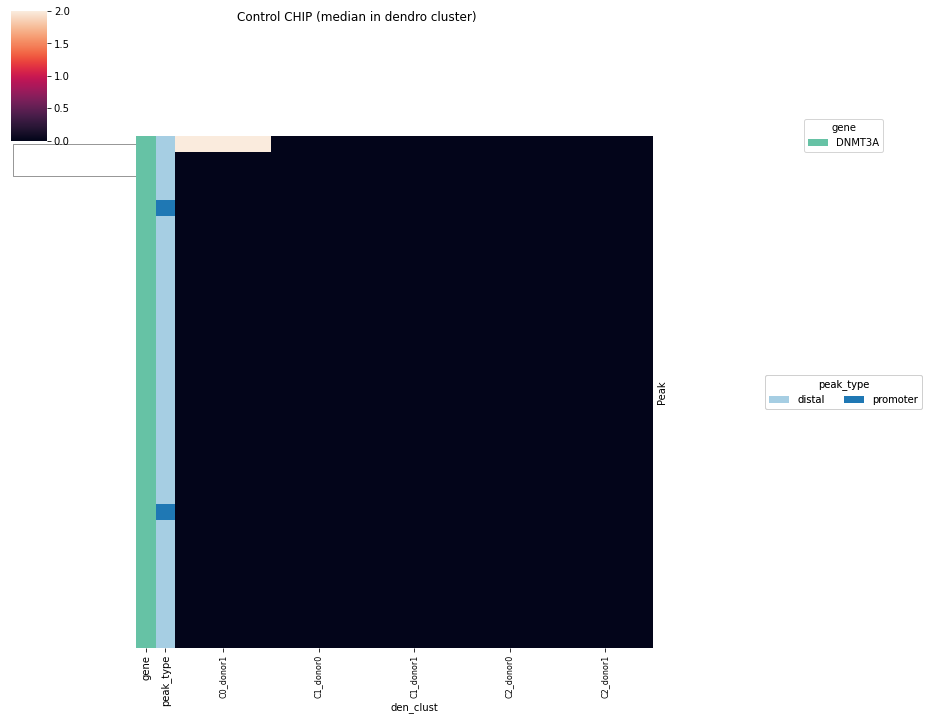

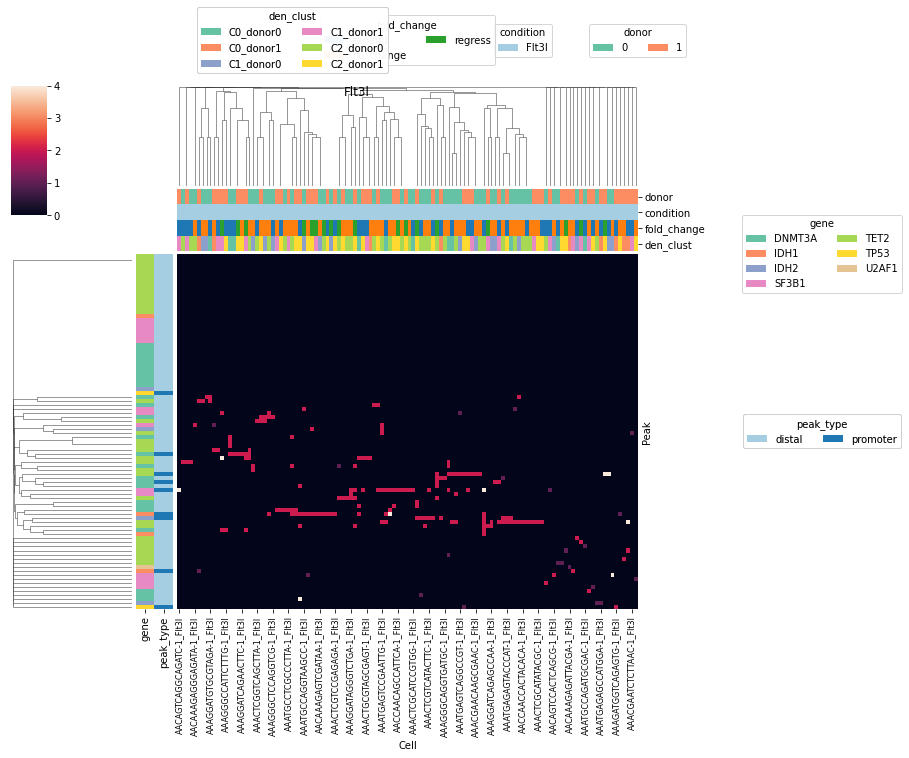

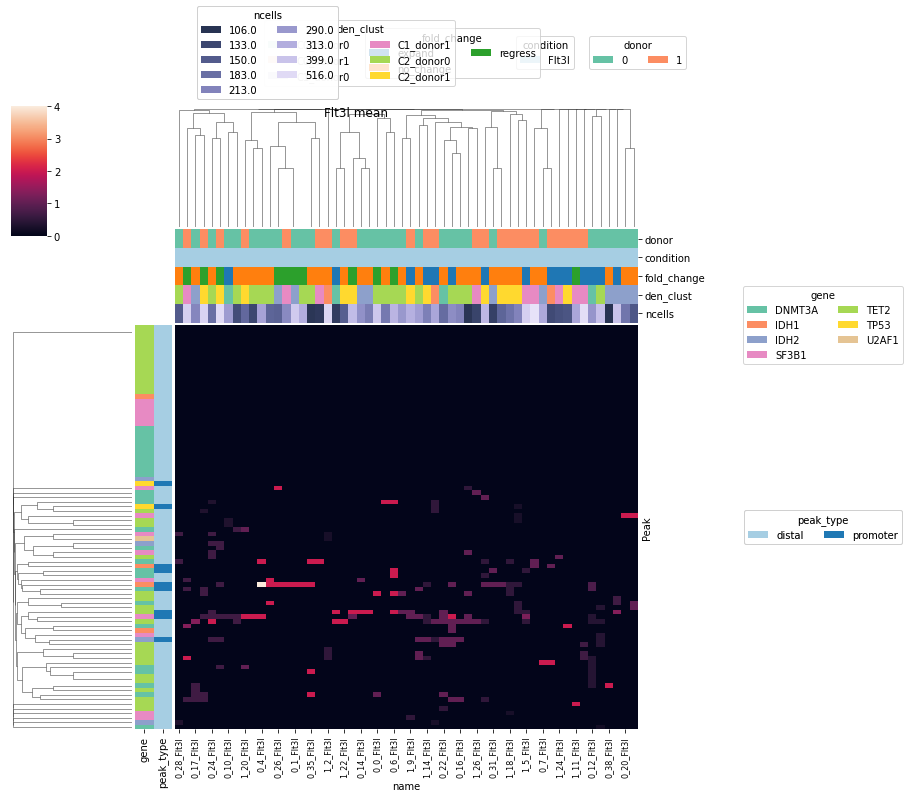

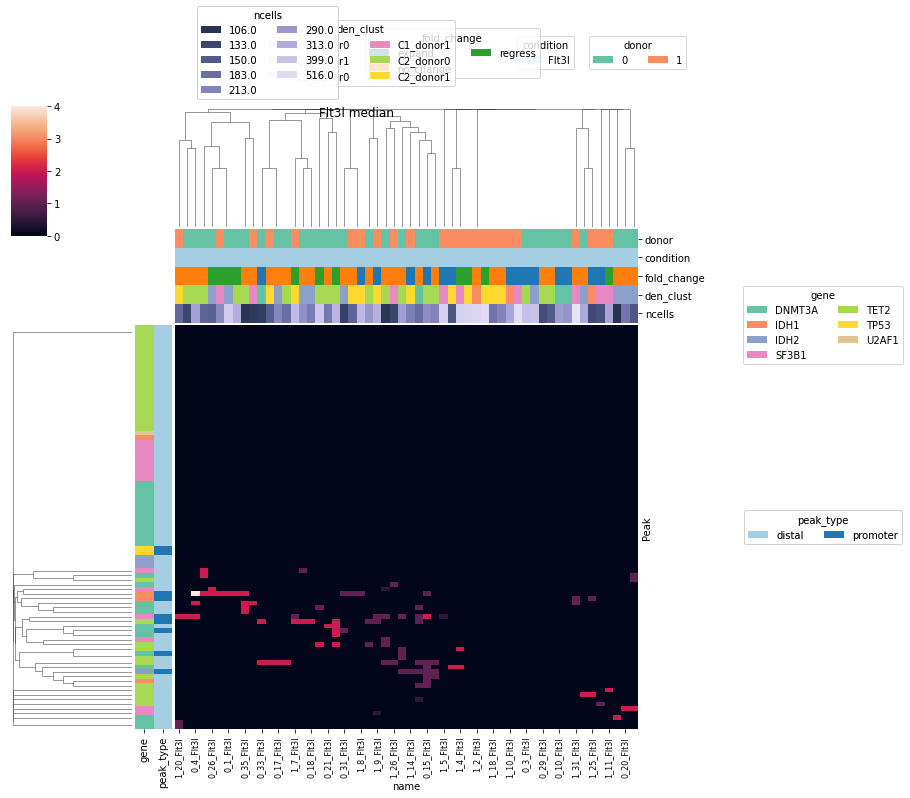

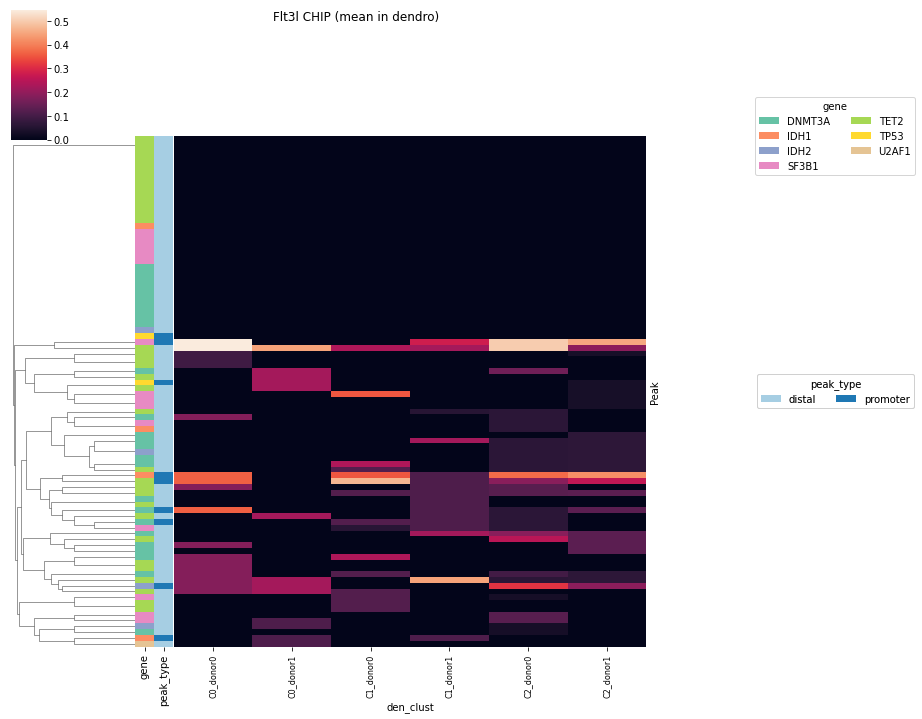

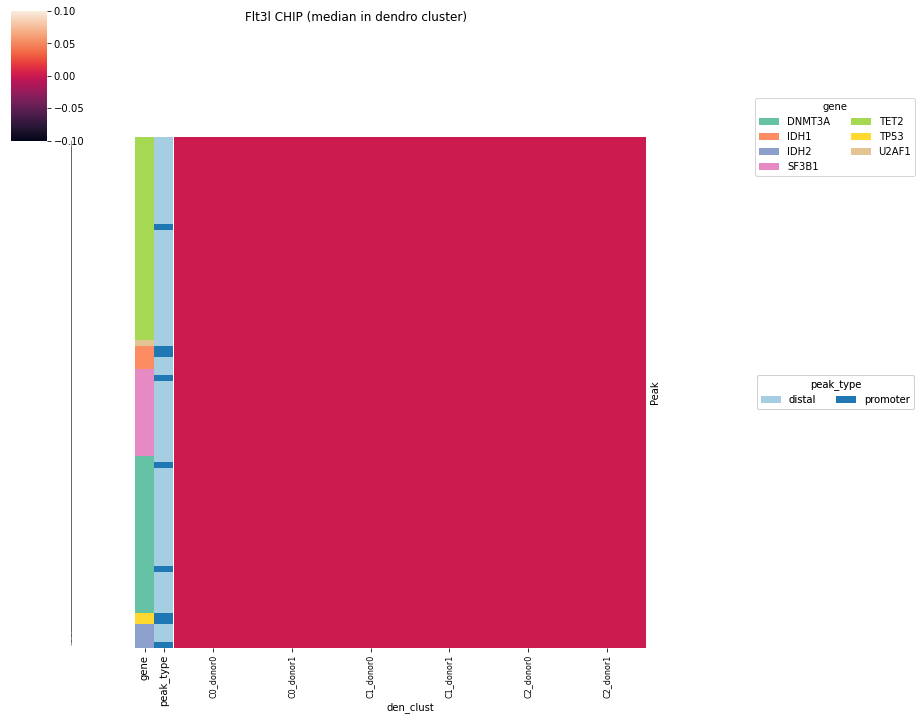

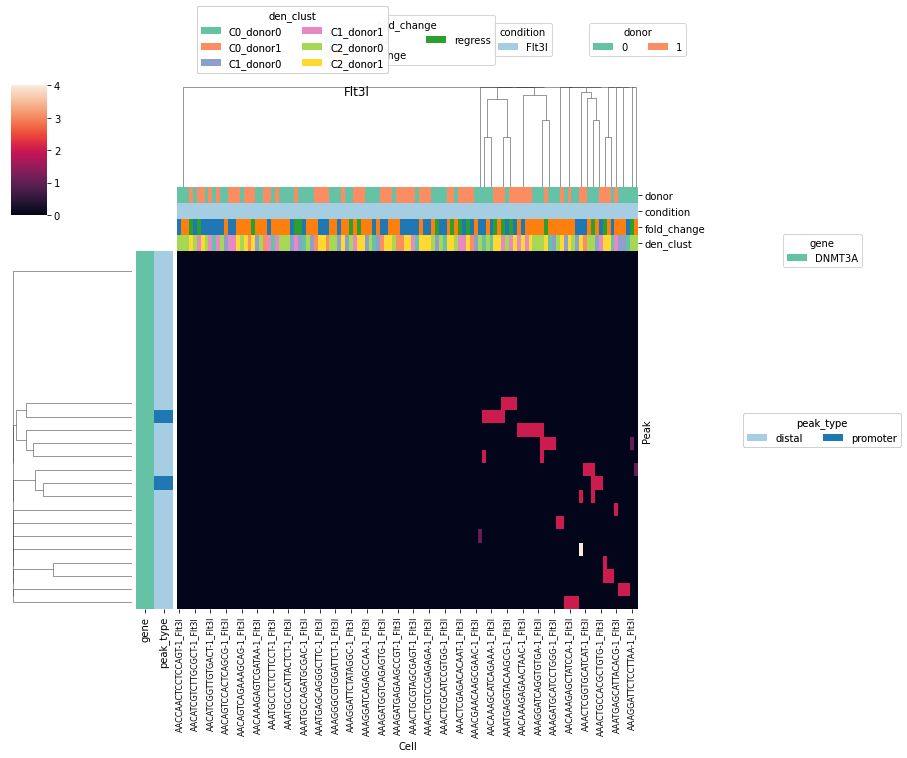

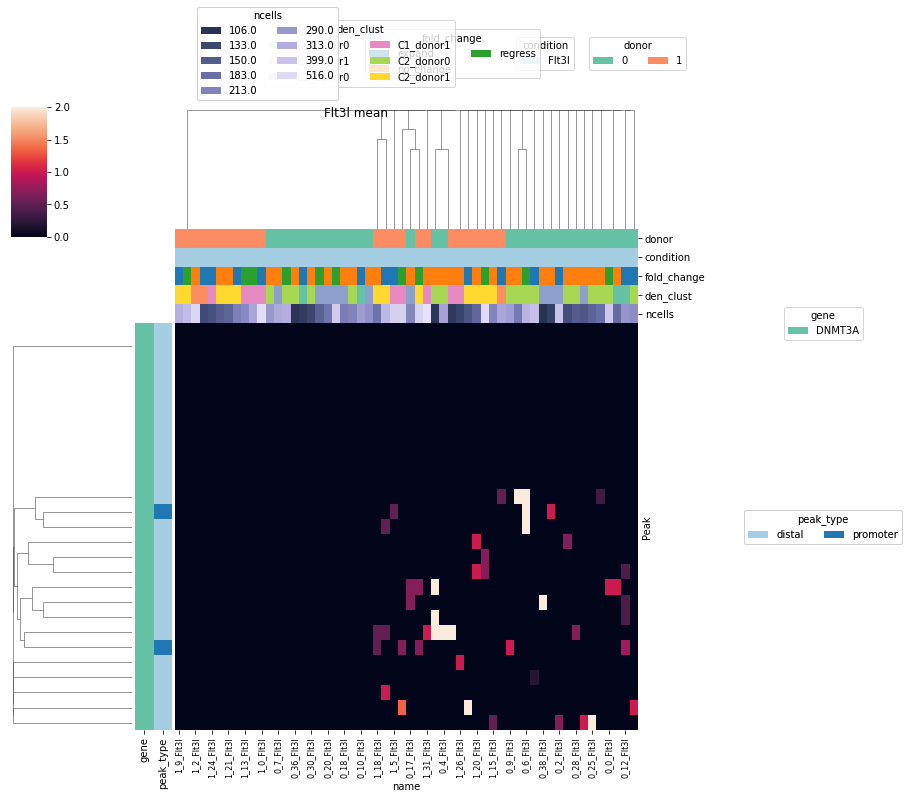

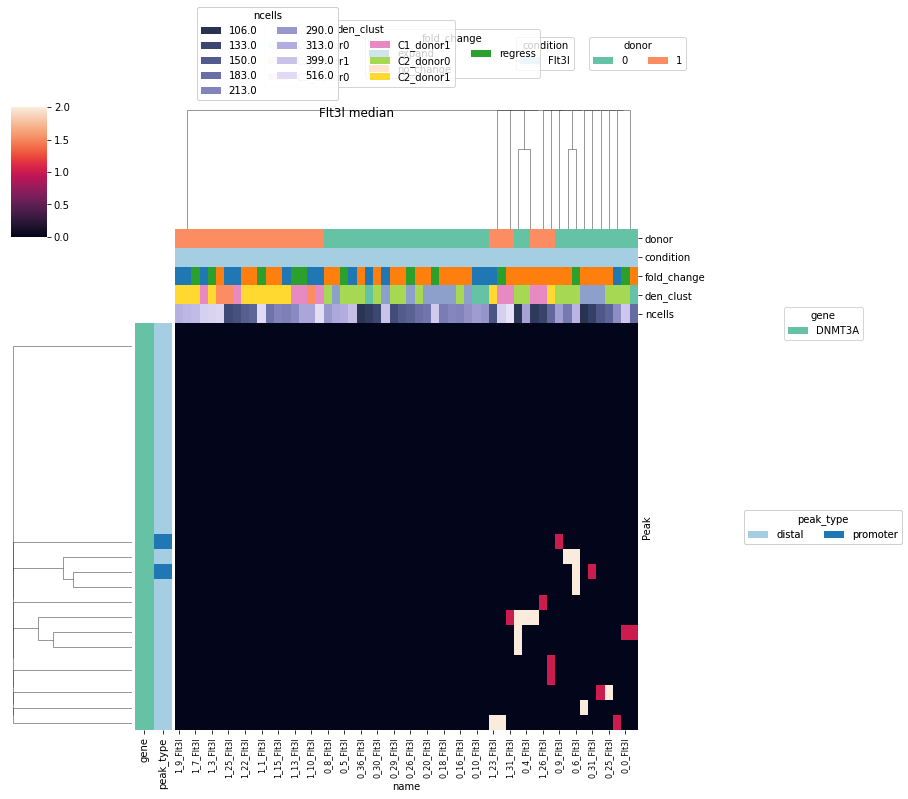

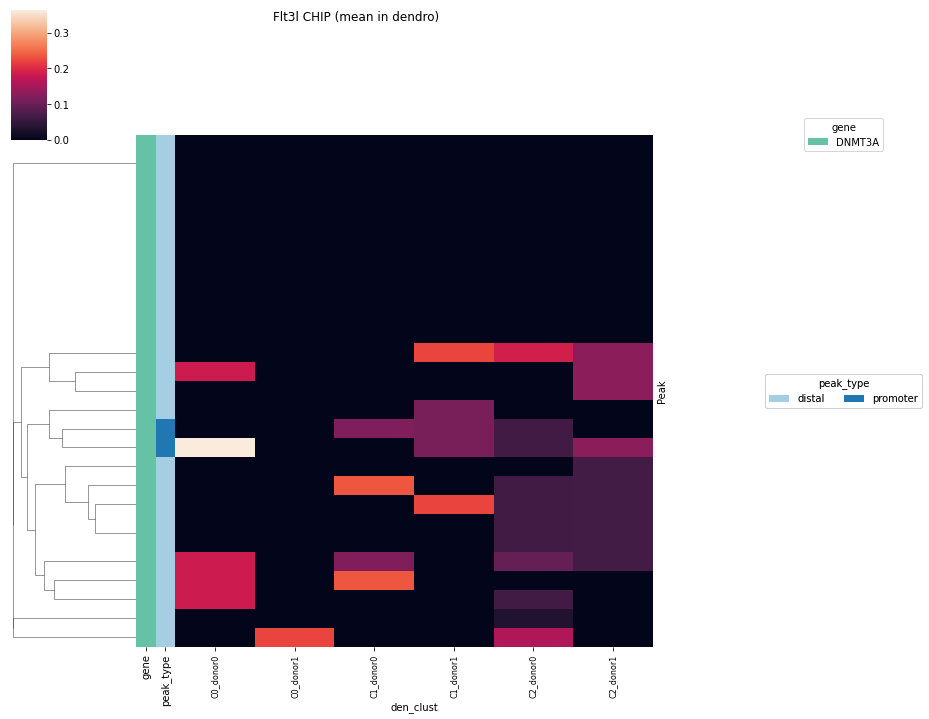

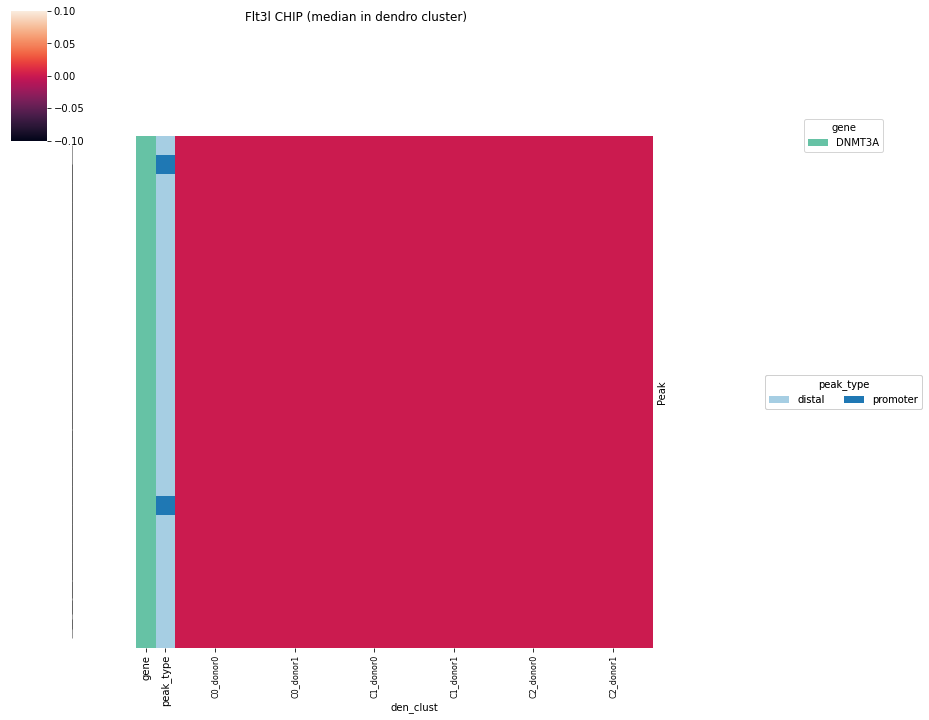

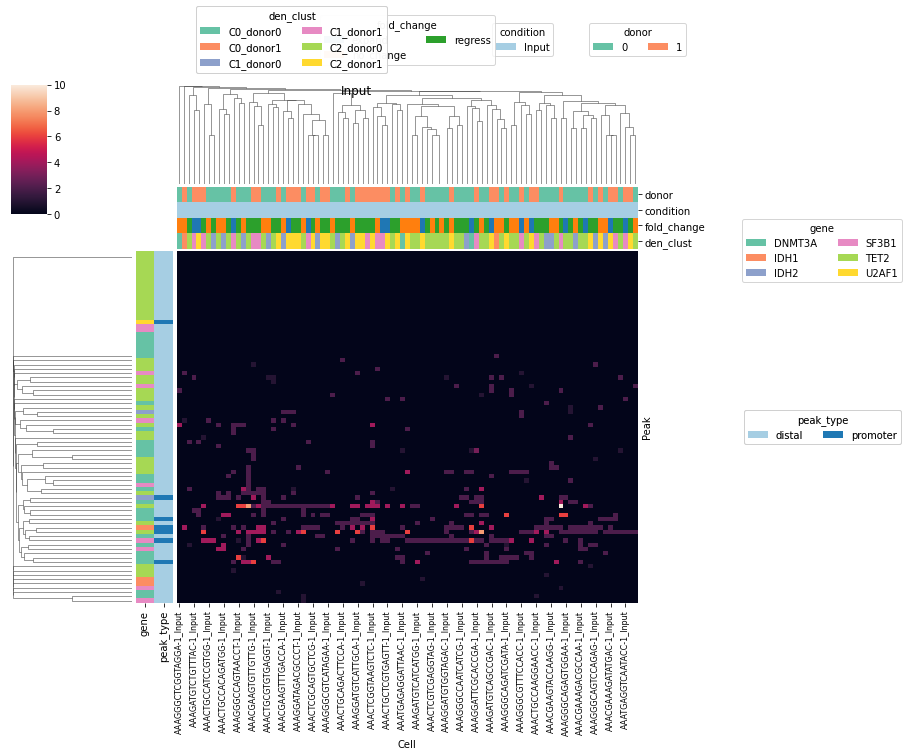

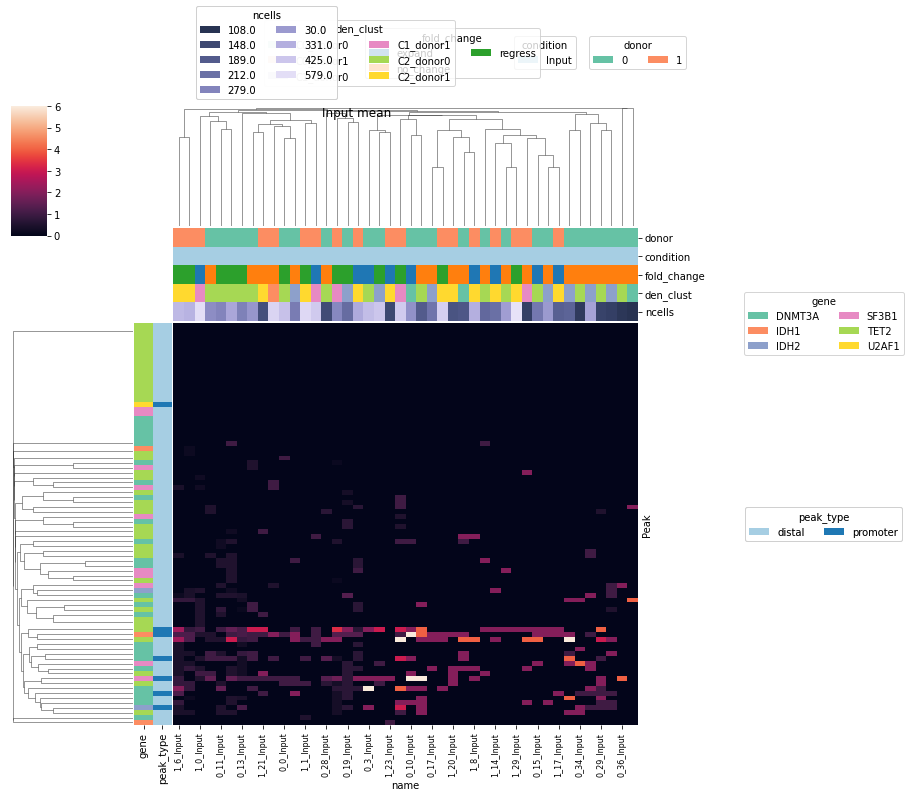

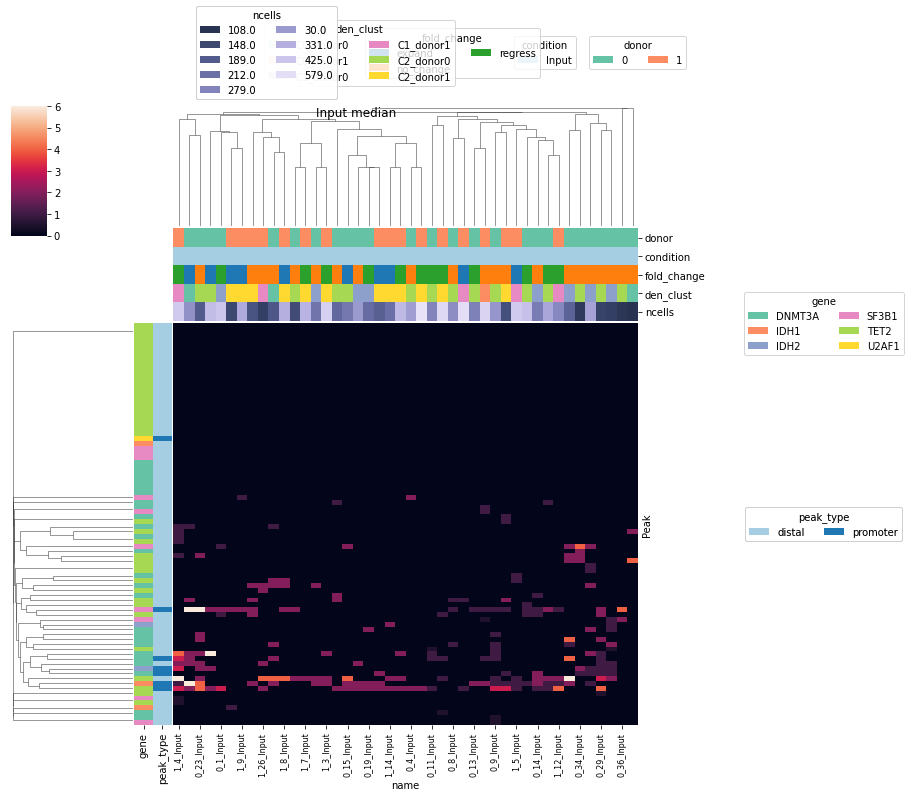

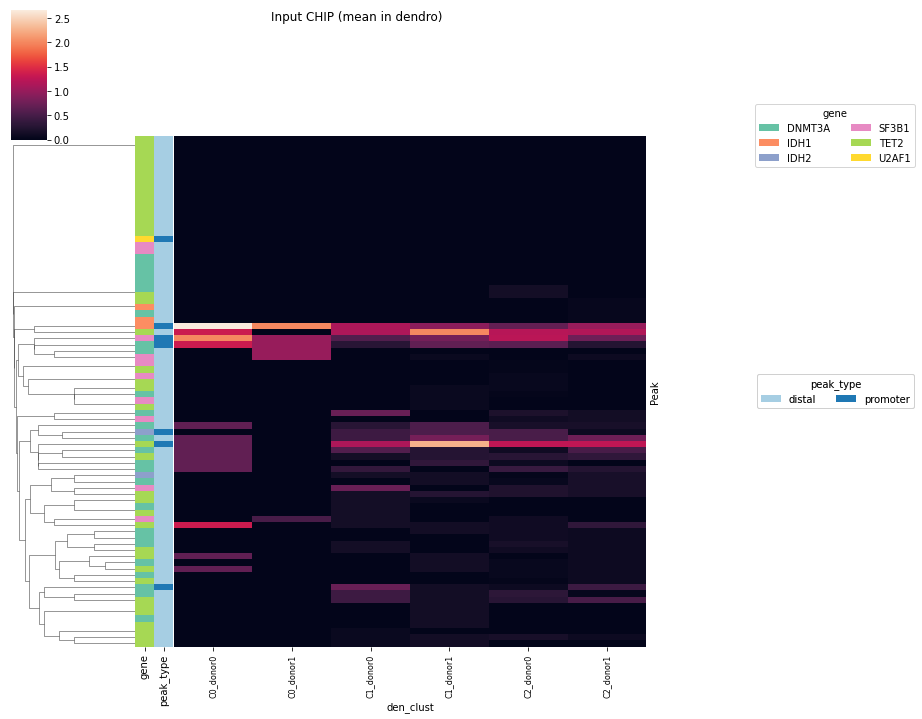

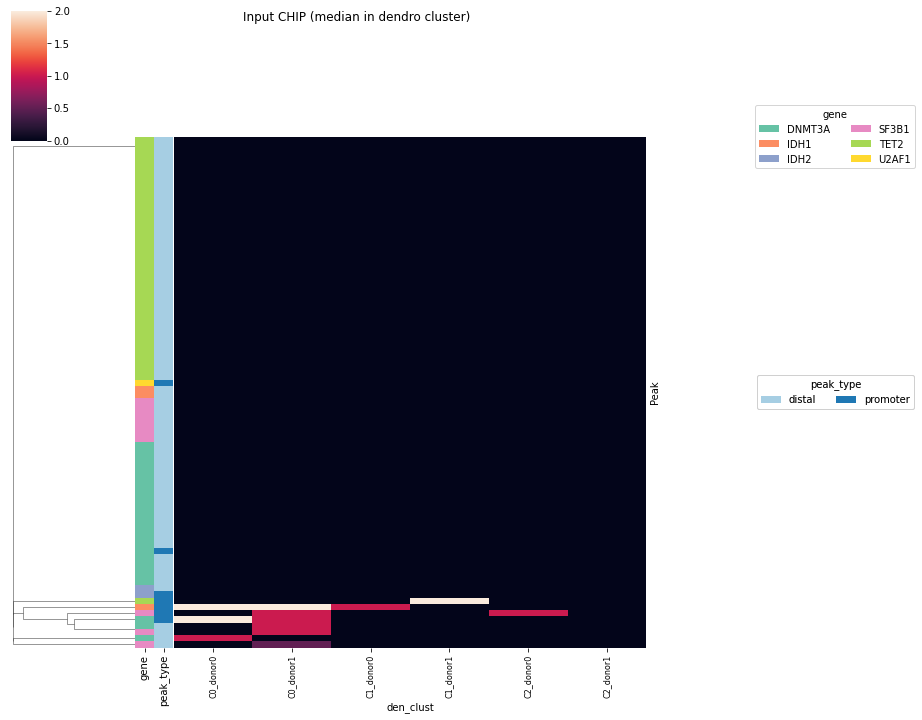

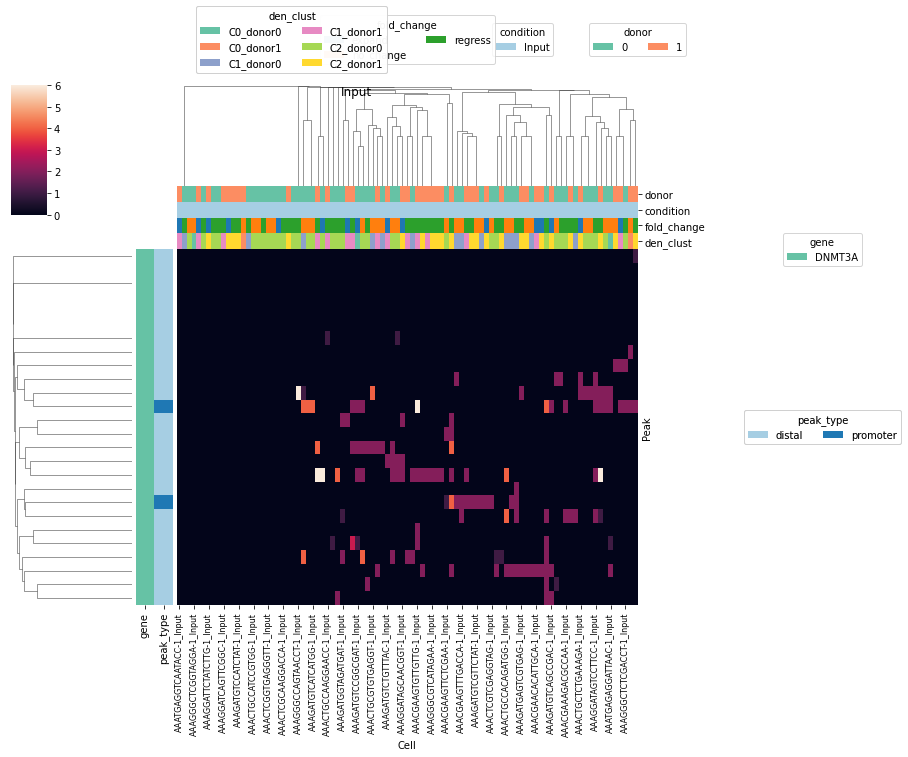

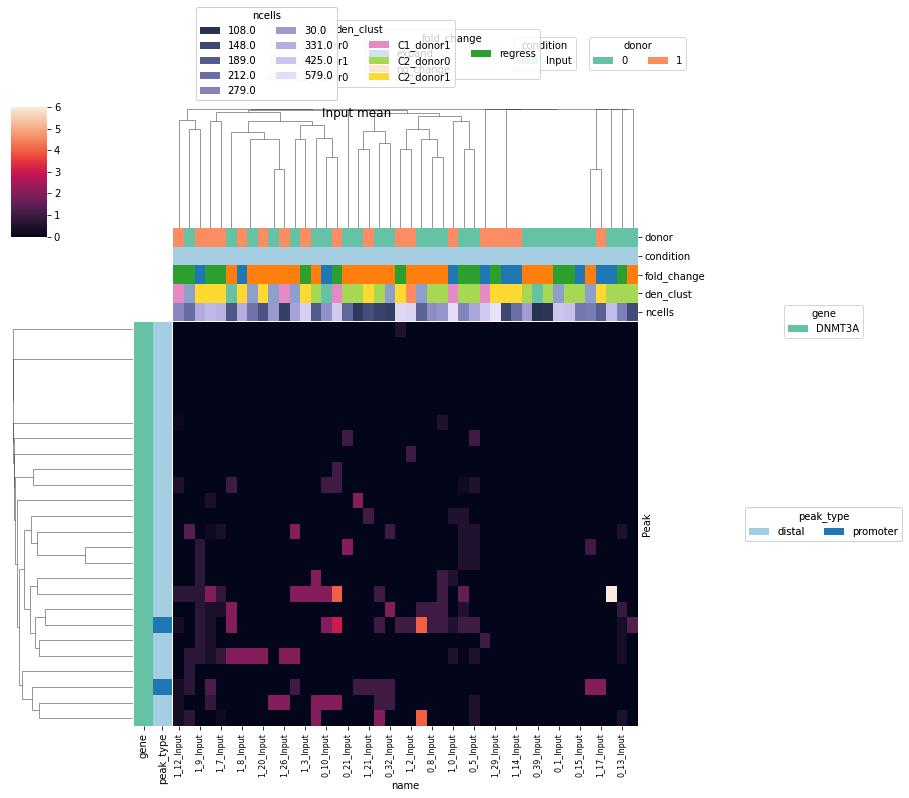

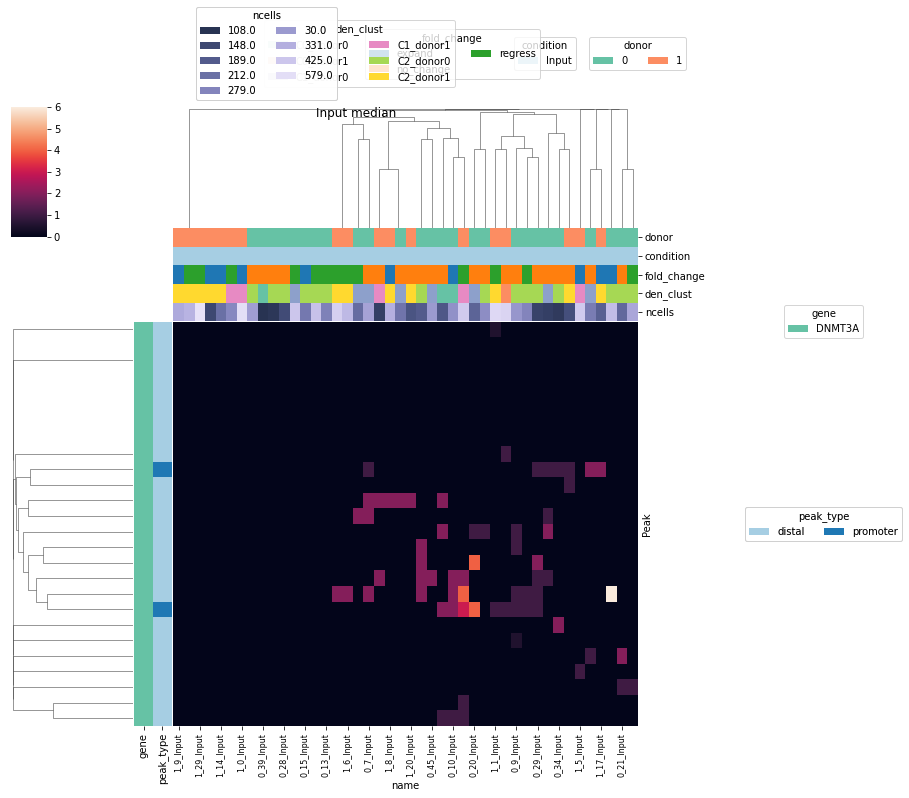

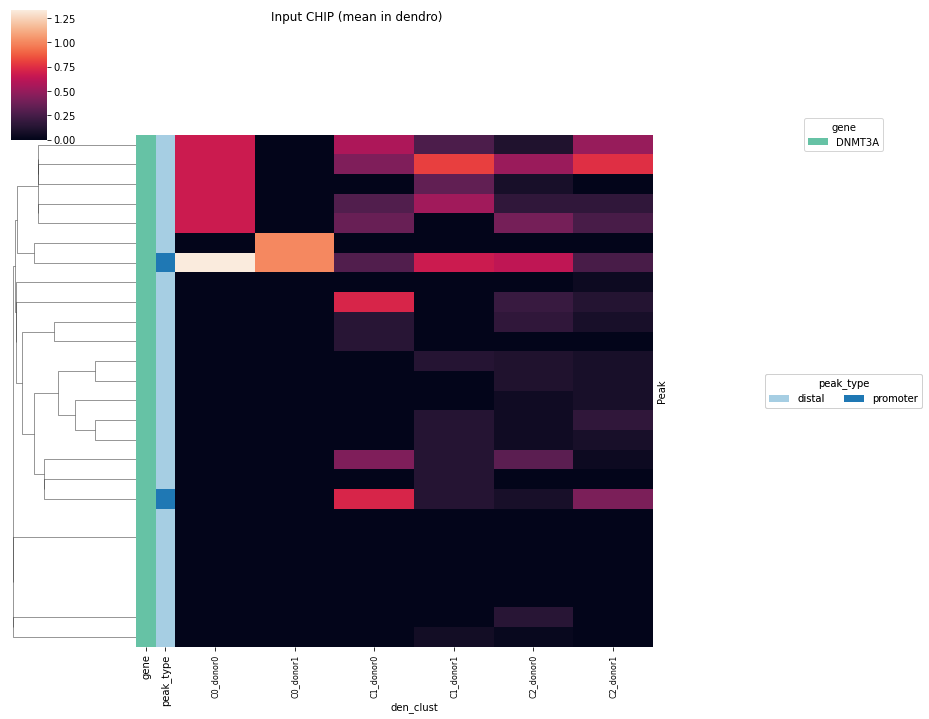

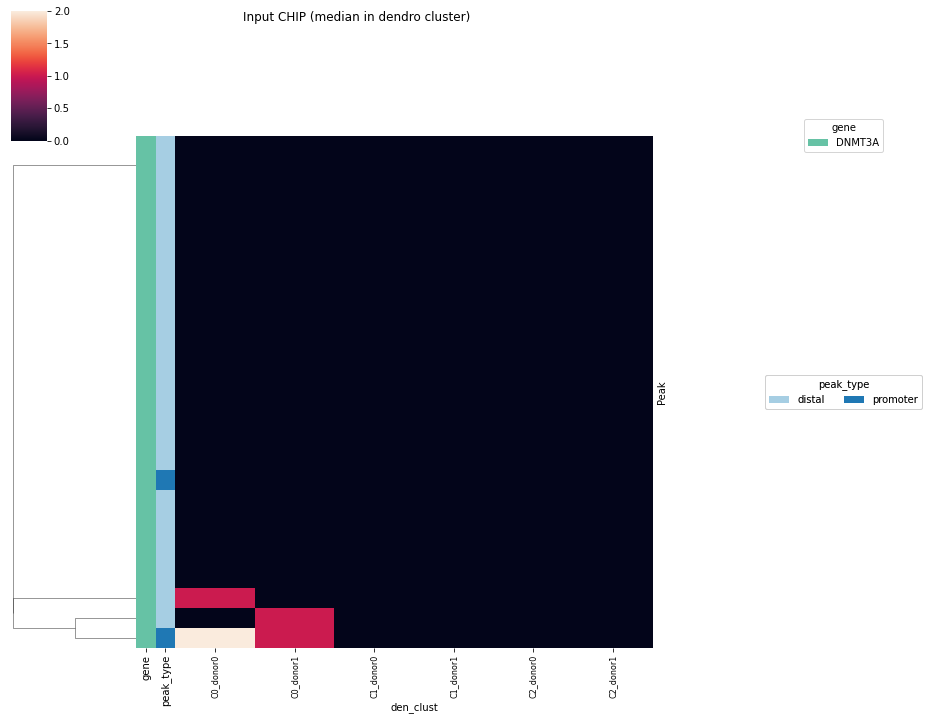

In [21]:
#curr_in = join(config["indir"], config['CBs'][0], 'outs')
for s in samples:
    print(s)
    peaks_dense, CBs, chip_peaks_dense, chip_anno = process_frag_indir(frag_indir,s)

    ###############################
    ## Plotting
    ###############################
    # CHIP peaks
    wrap_plots(chip_peaks_dense, chip_anno, cells_meta, name=s, gene_name="CHIP", clones_meta=clones_meta)
    
    # DNMT3 peaks
    dnmt3a_peaks_dense, dnmt3a_anno = peaks_gene(chip_peaks_dense, "DNMT3A", chip_anno)
    wrap_plots(dnmt3a_peaks_dense, dnmt3a_anno, cells_meta, name=s, gene_name="DNMT3A", clones_meta=clones_meta)
   

## Run for each donor separately

In [22]:
donors = cells_meta["donor"].unique()
donors

array([0, 1])

Control


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexe

Flt3l


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xli

Input


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

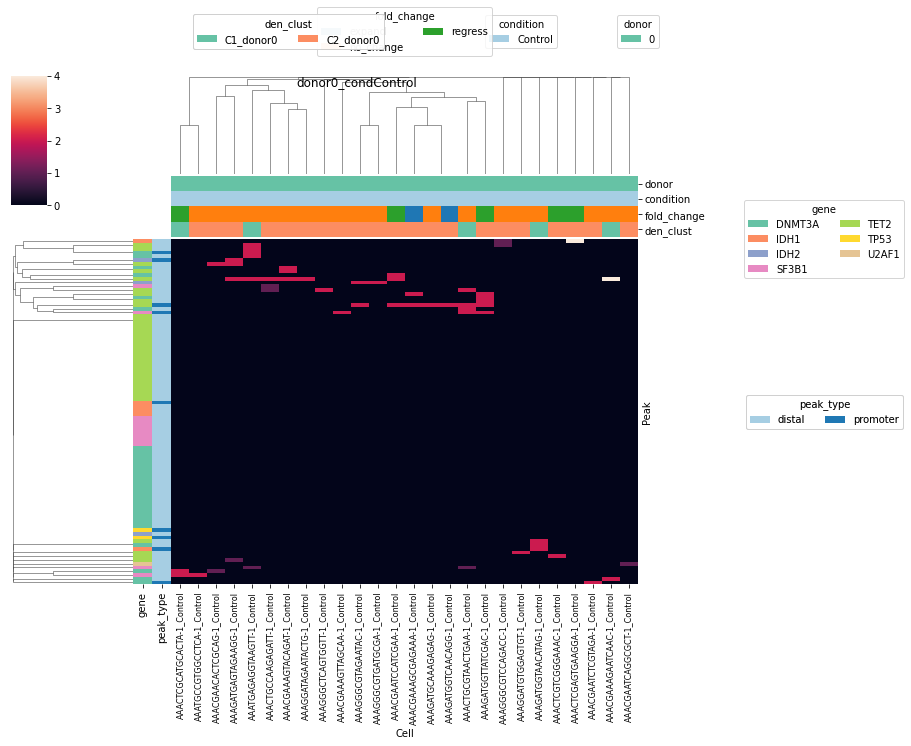

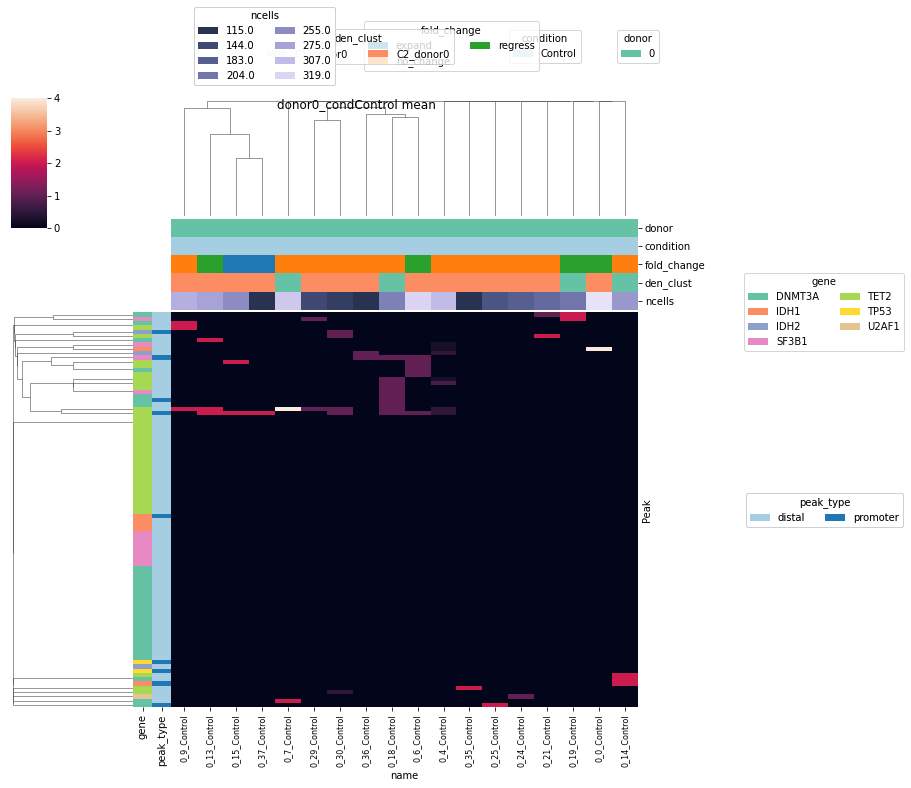

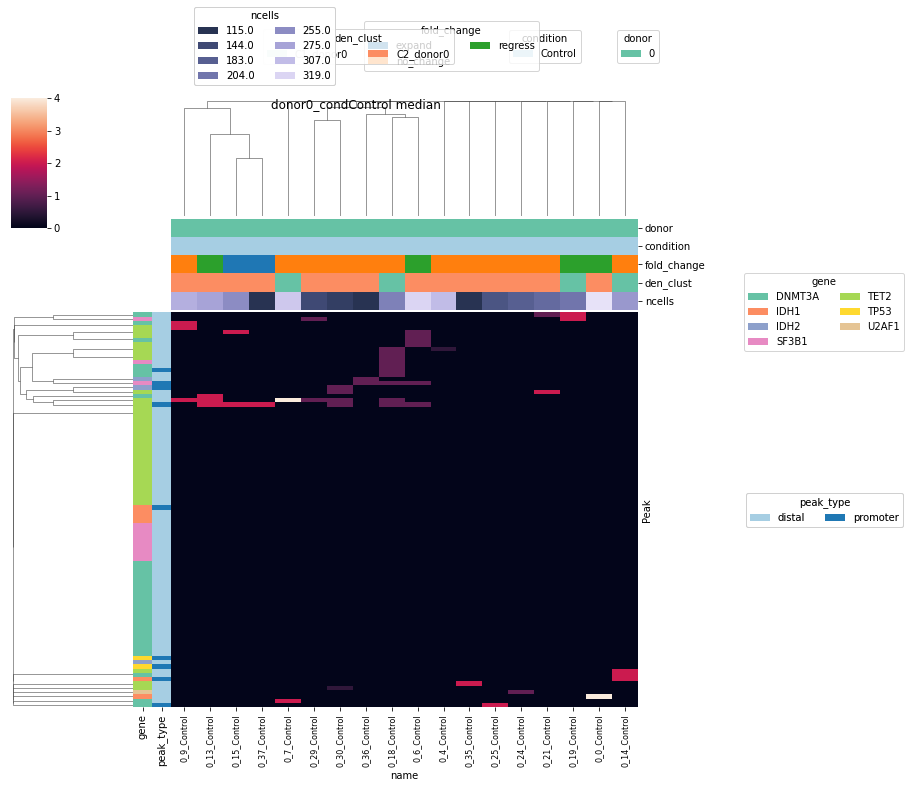

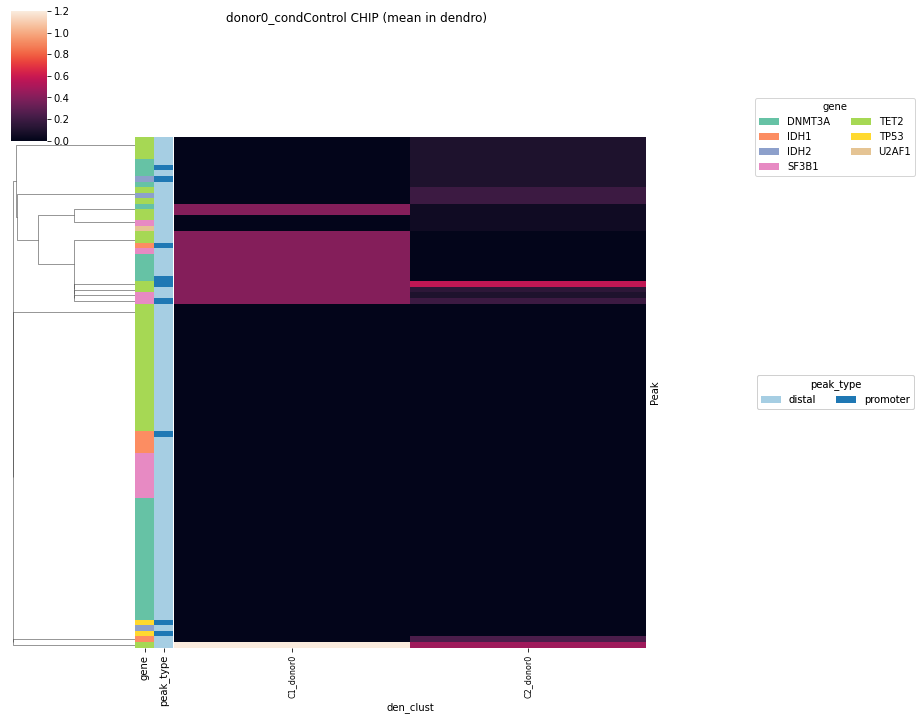

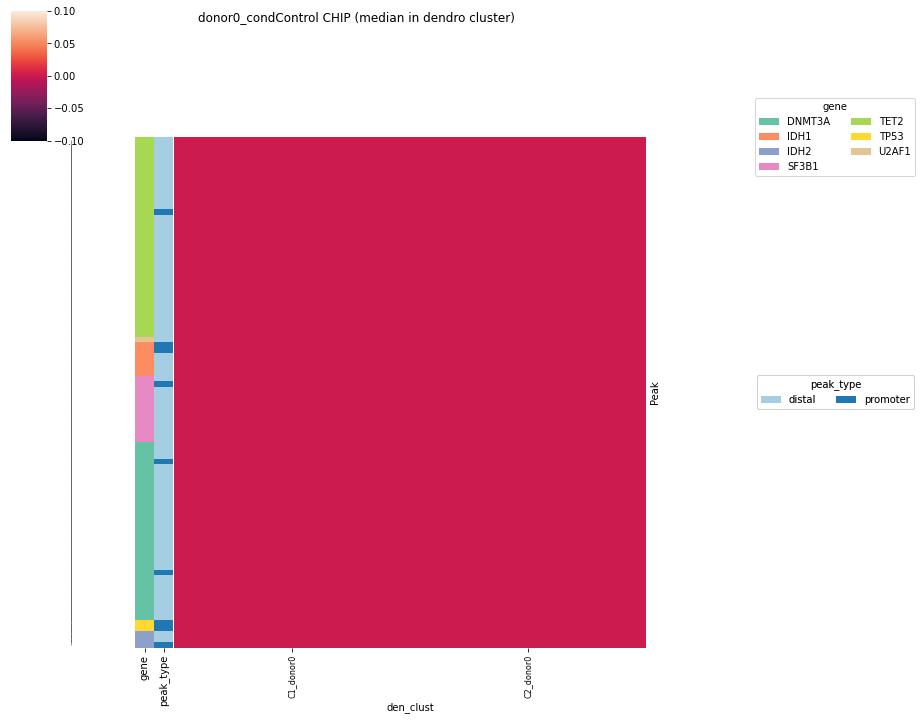

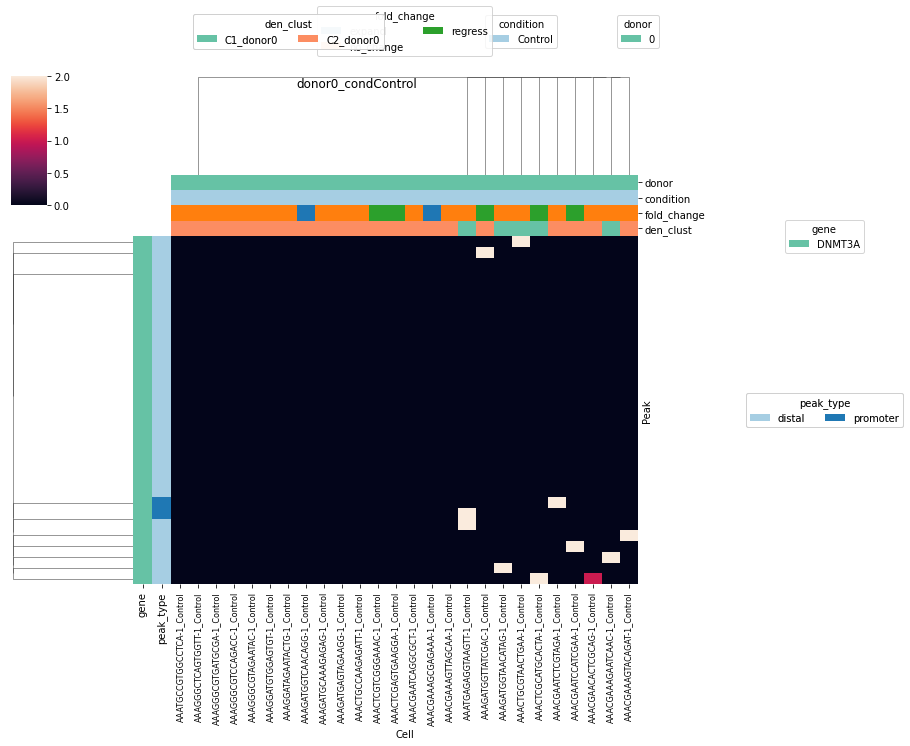

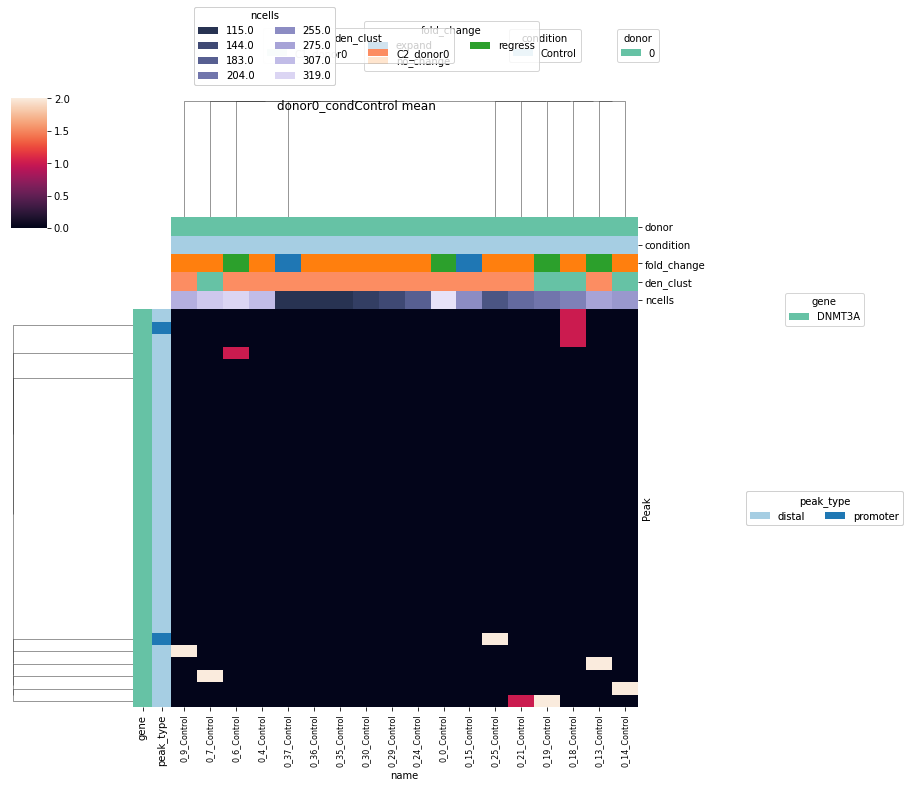

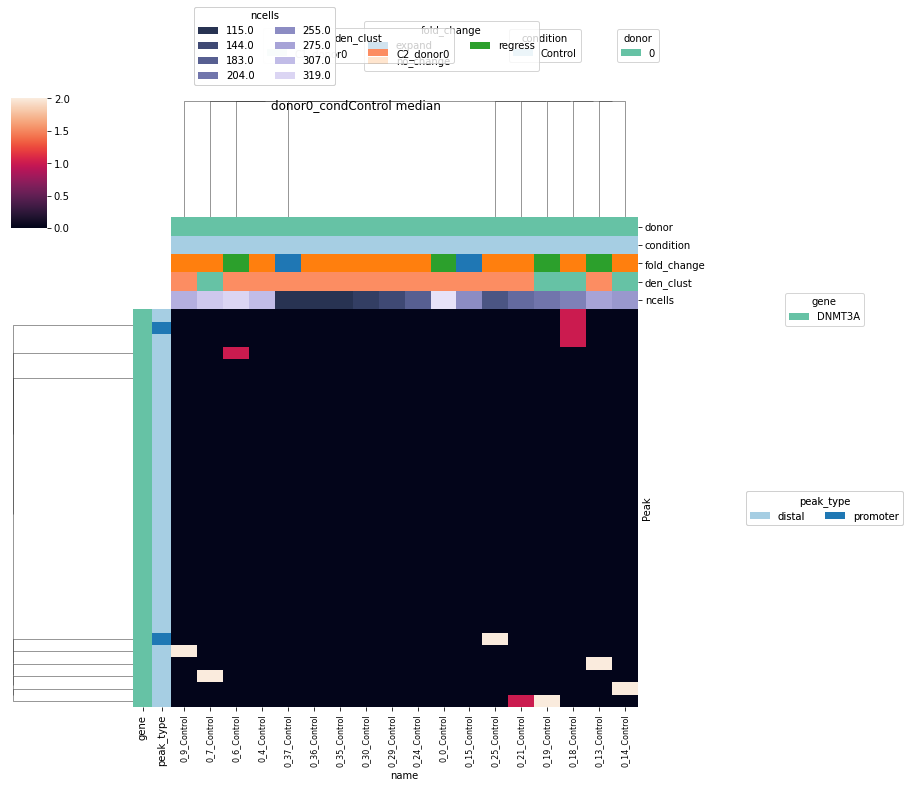

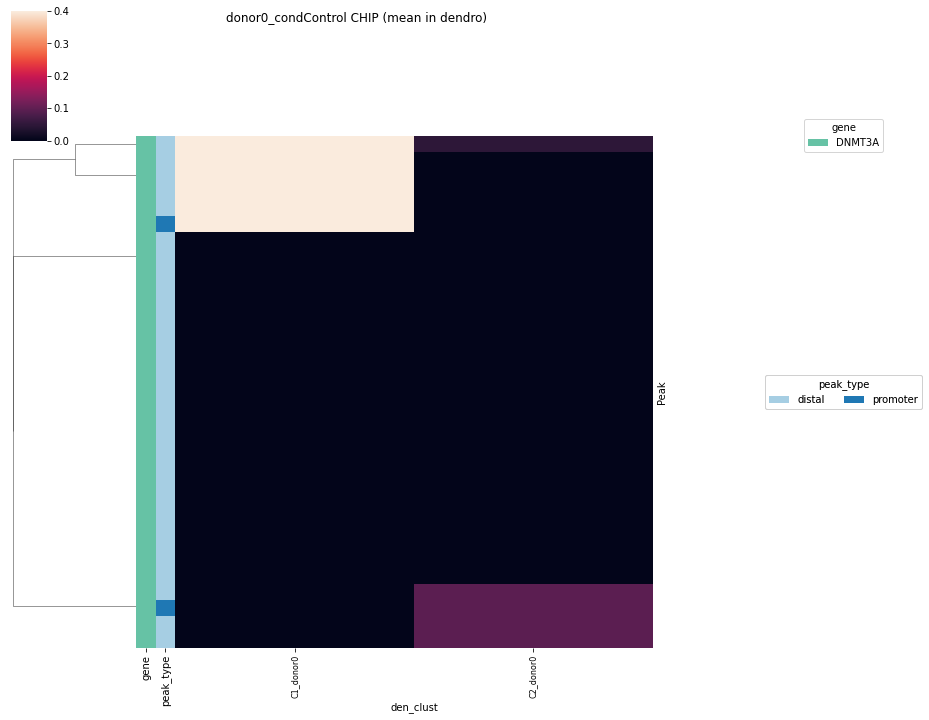

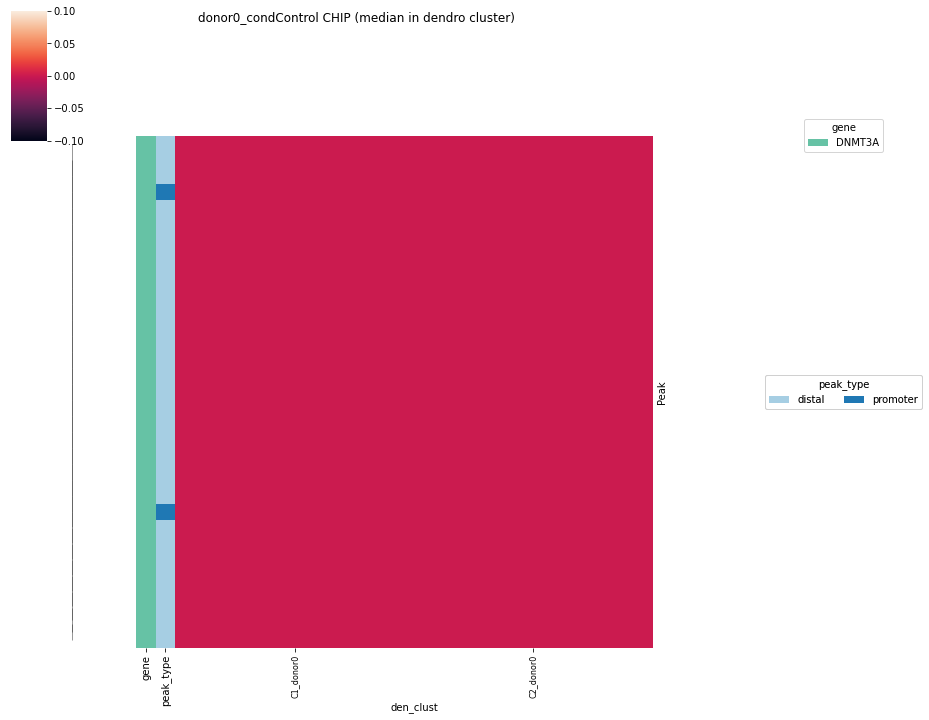

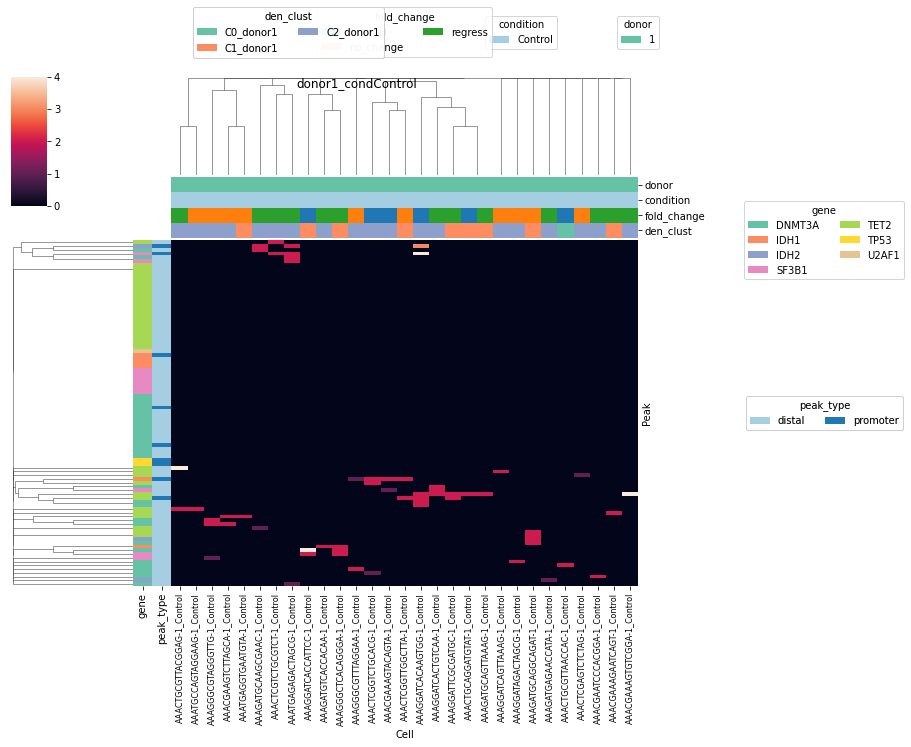

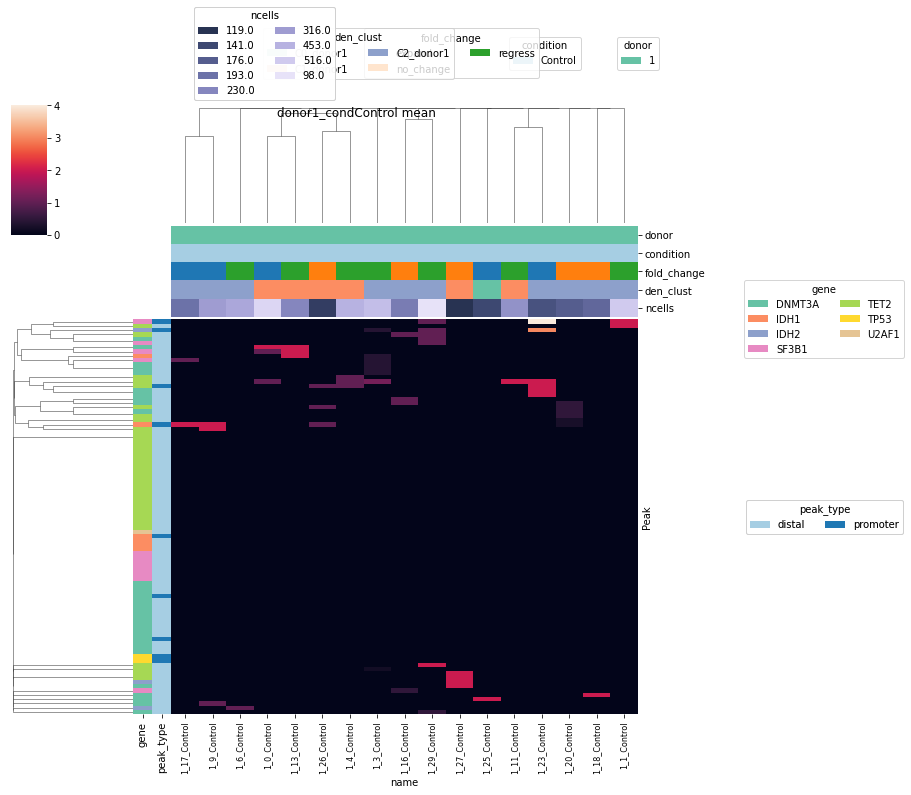

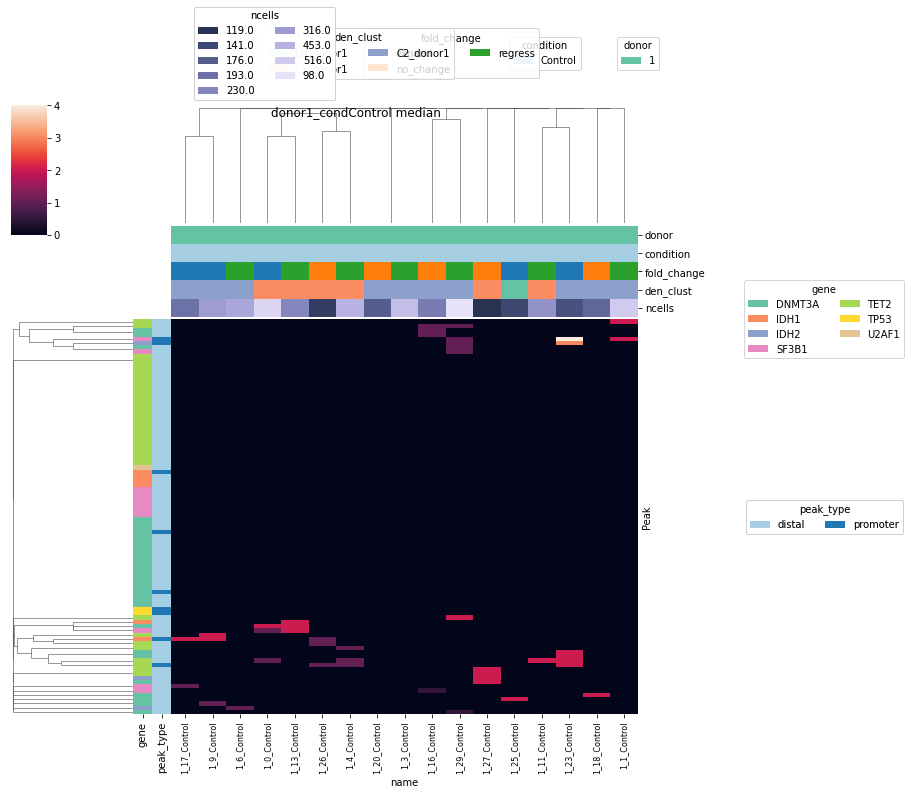

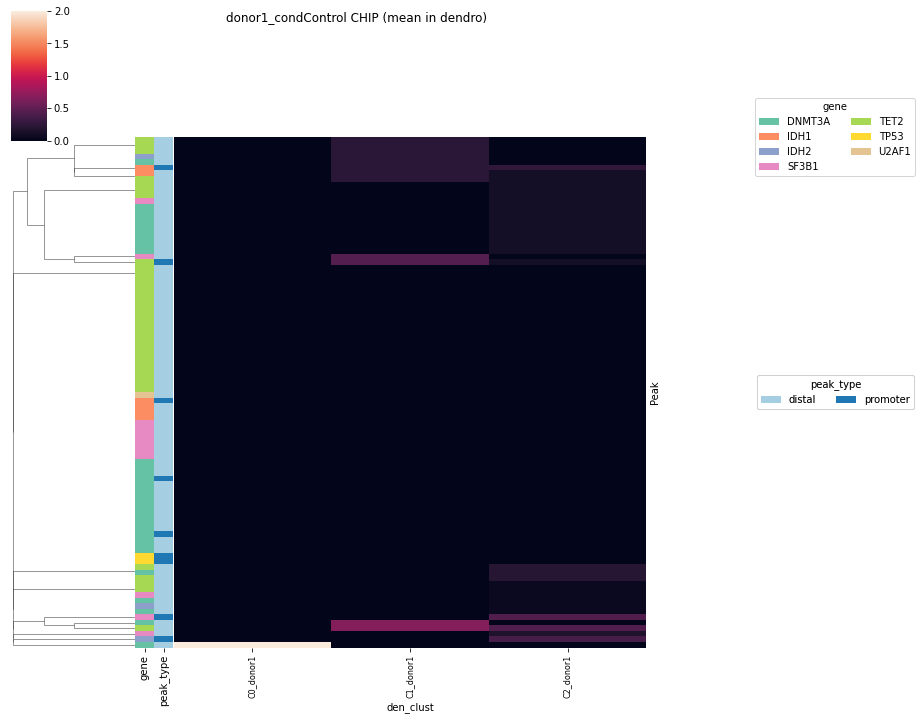

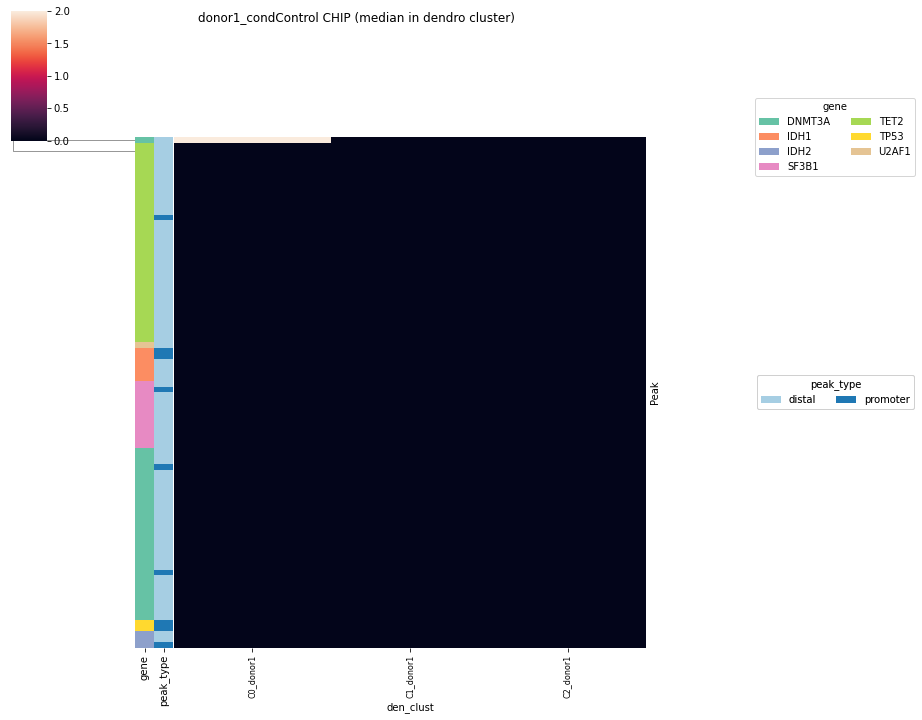

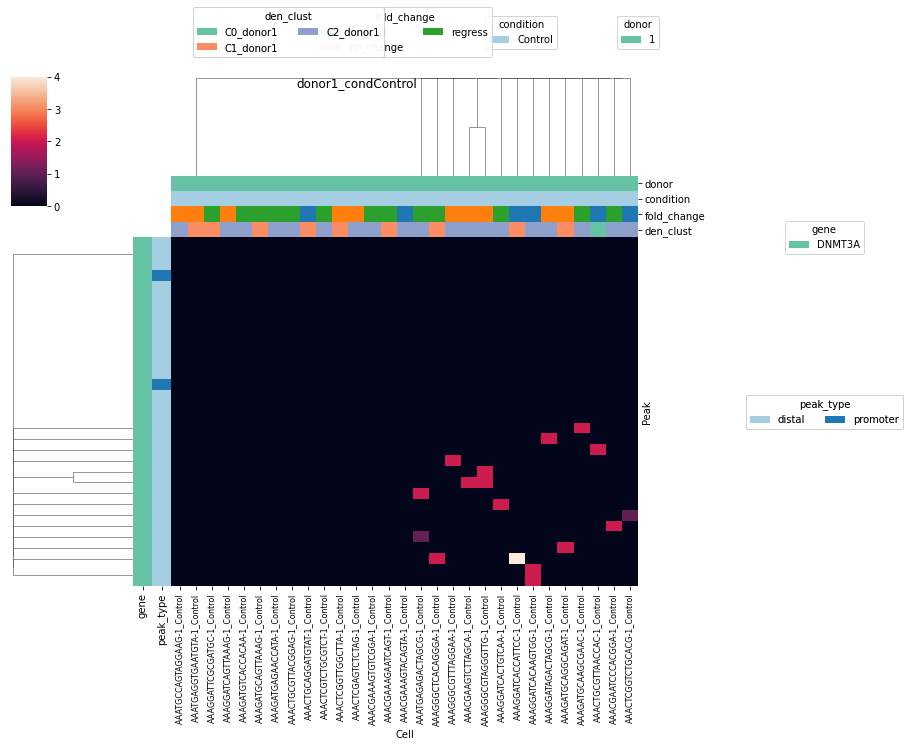

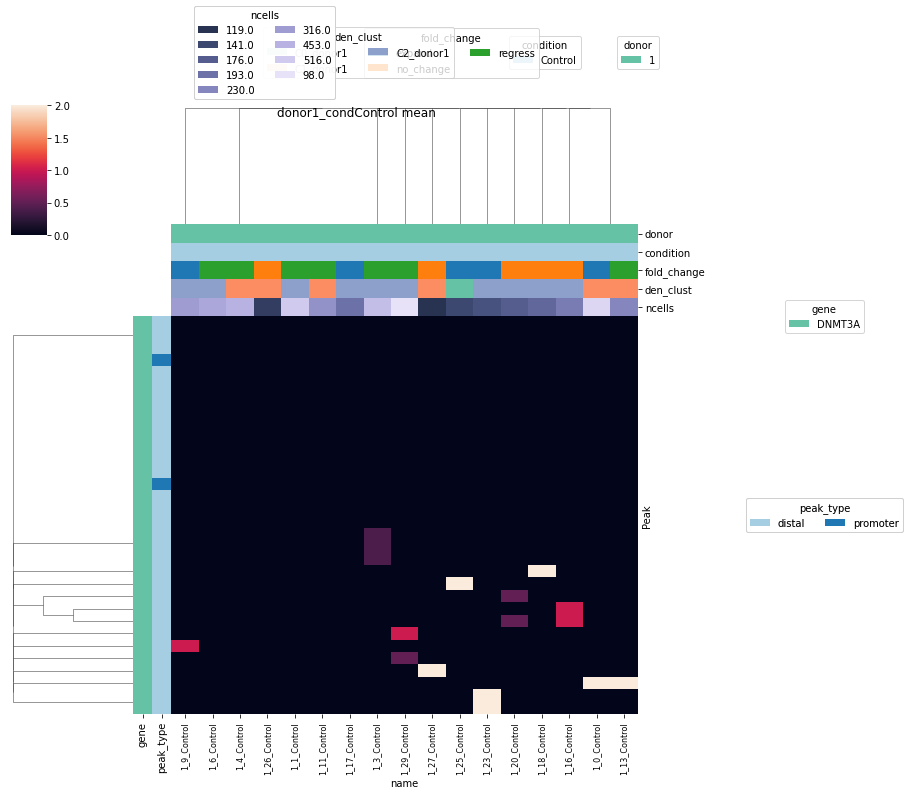

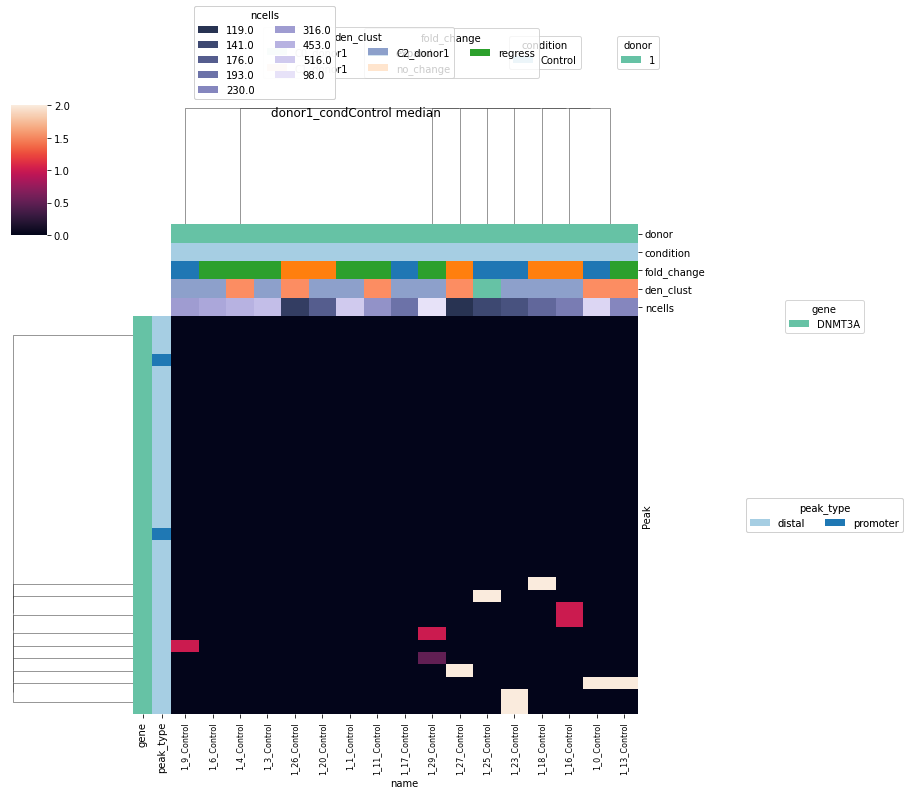

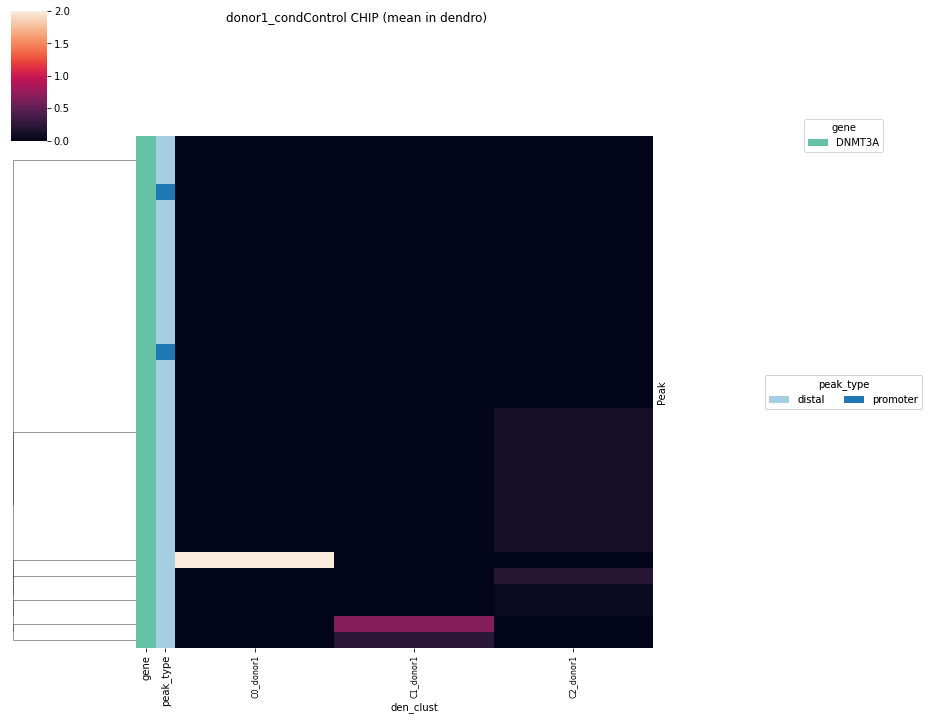

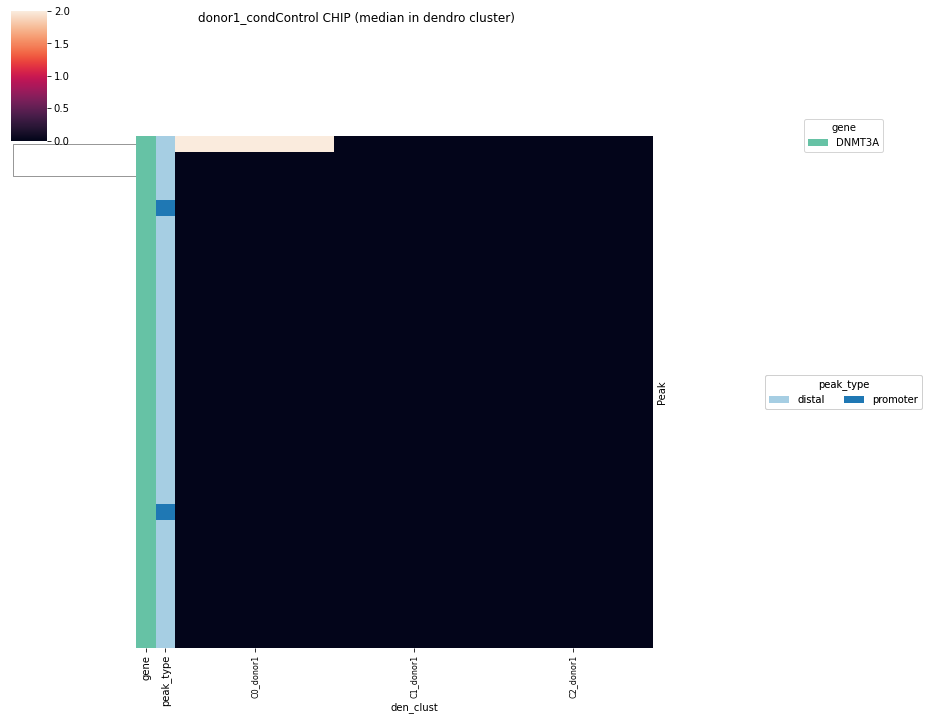

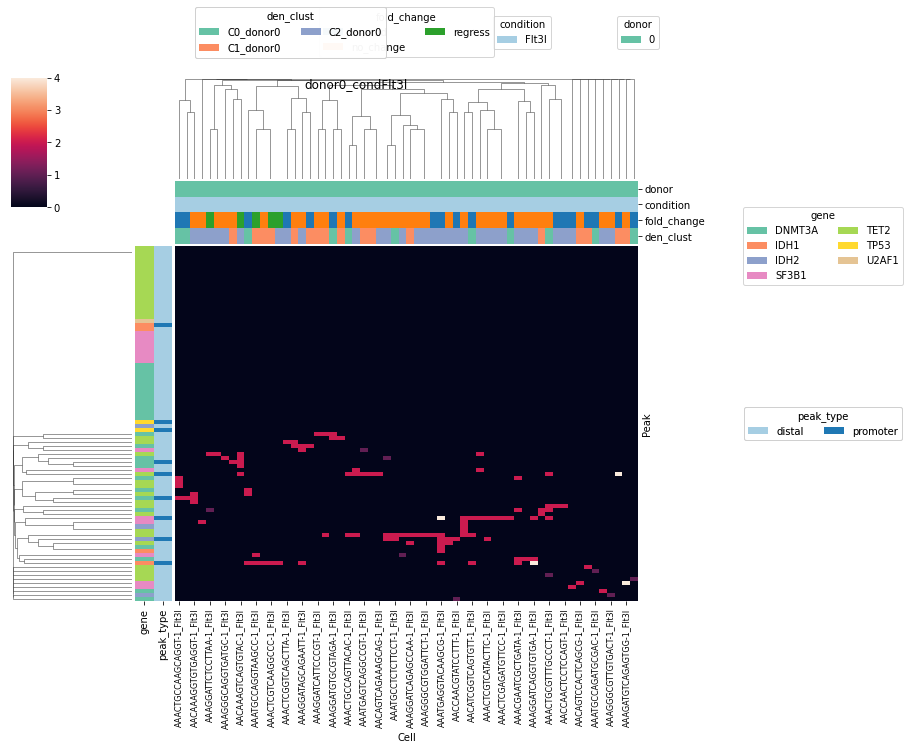

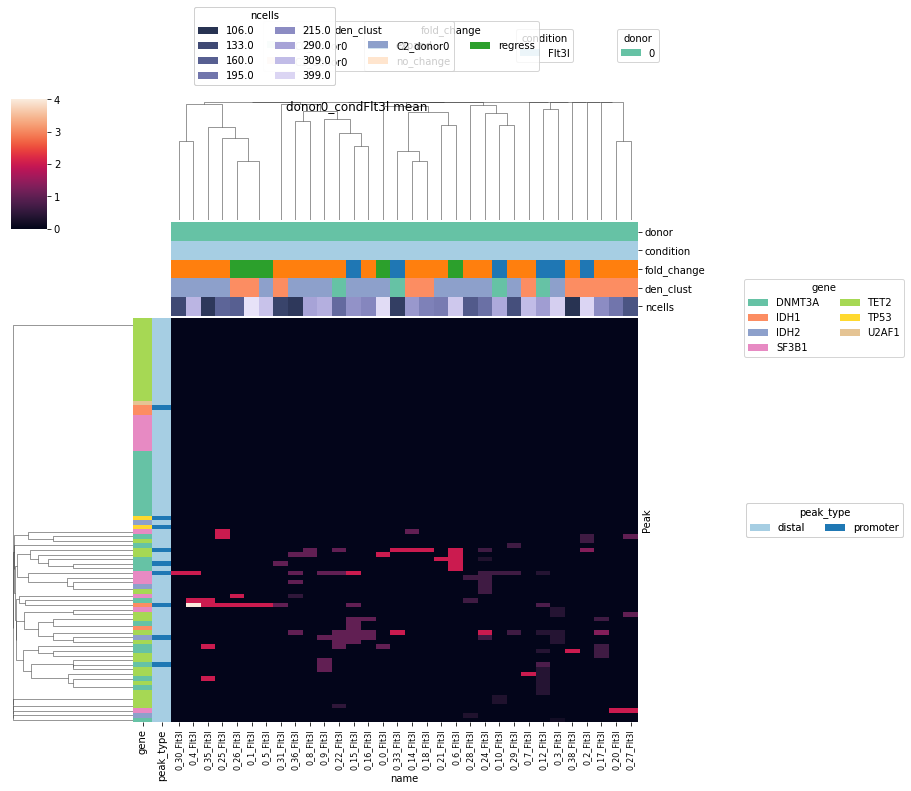

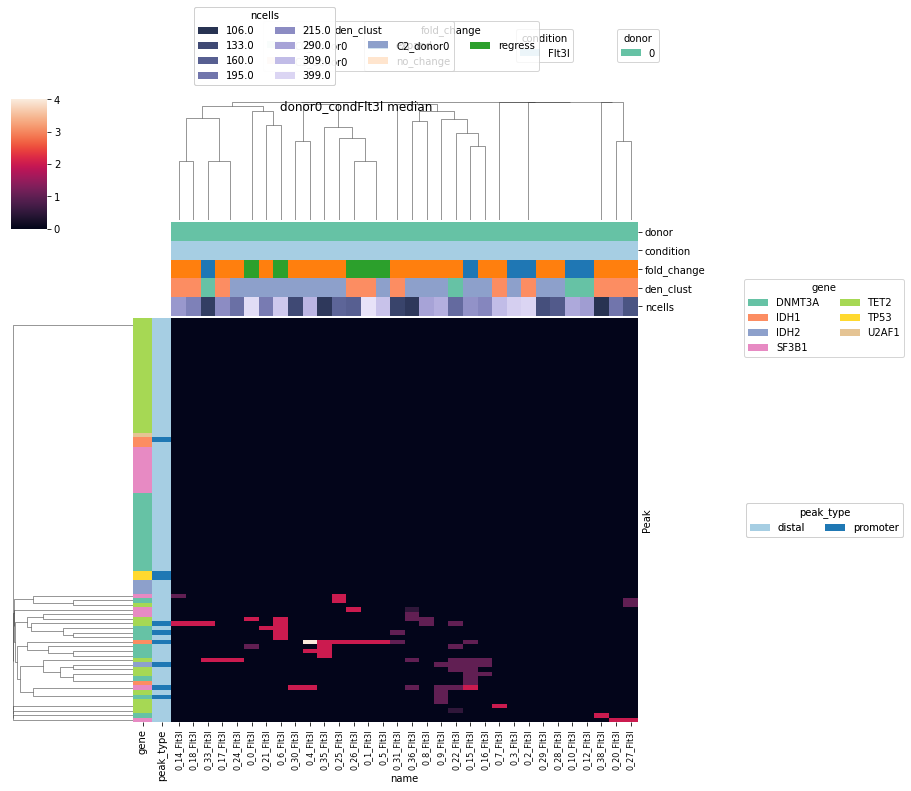

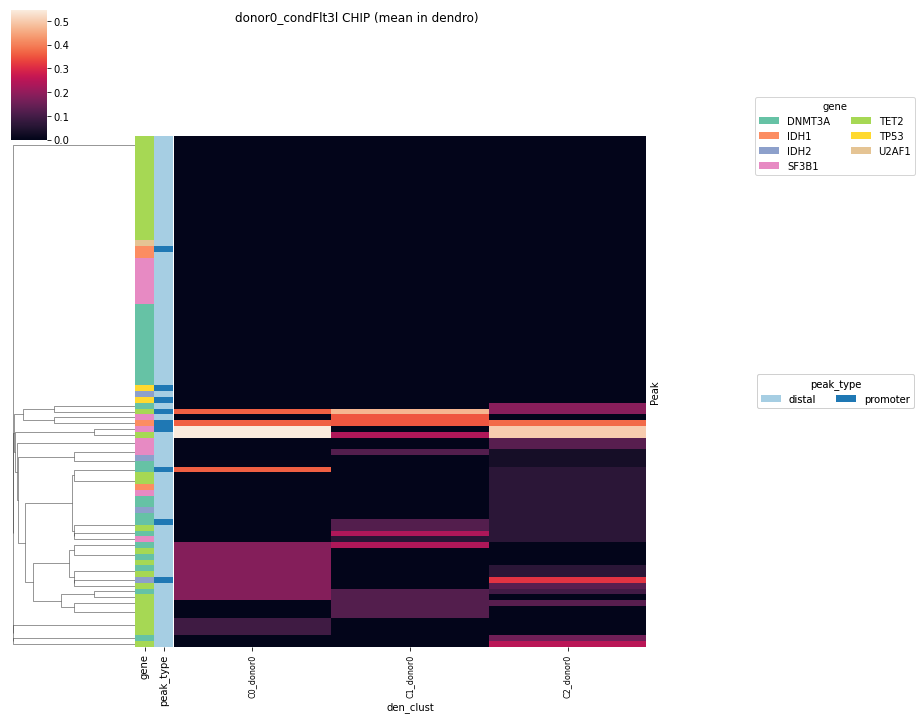

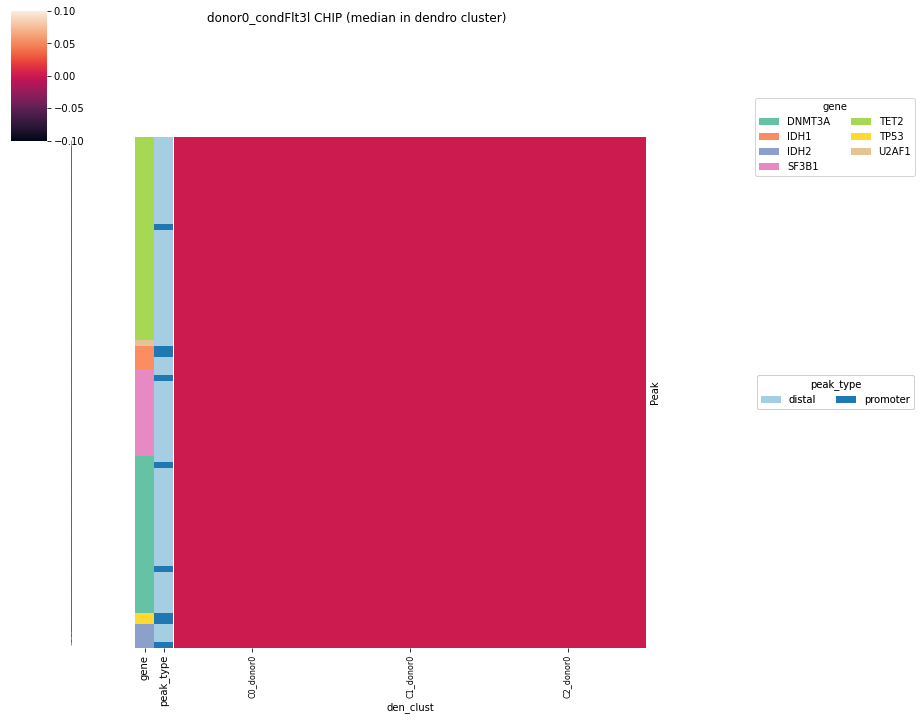

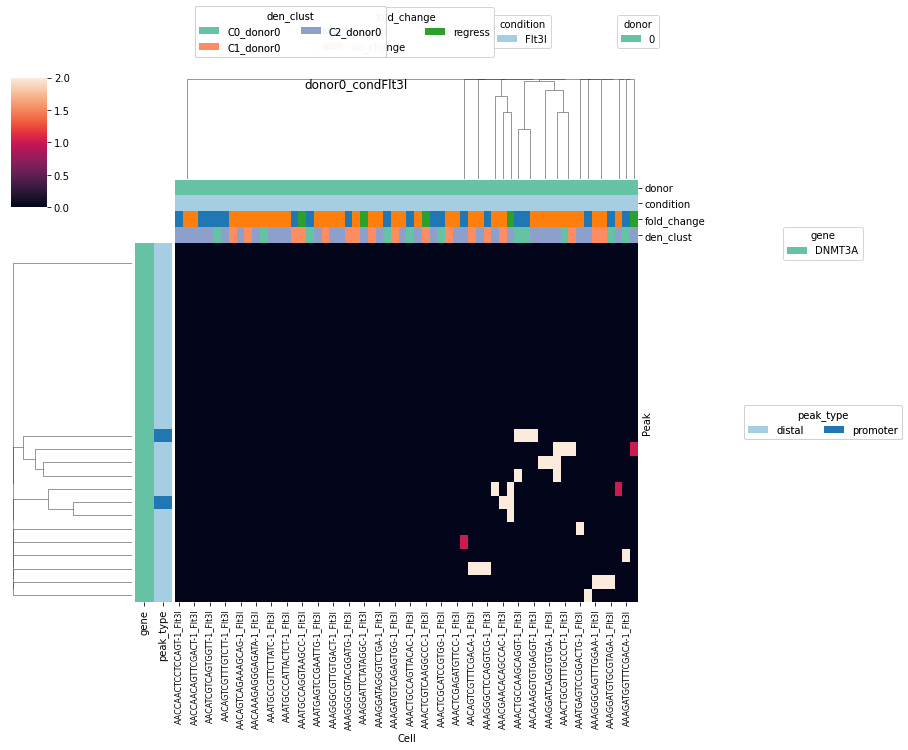

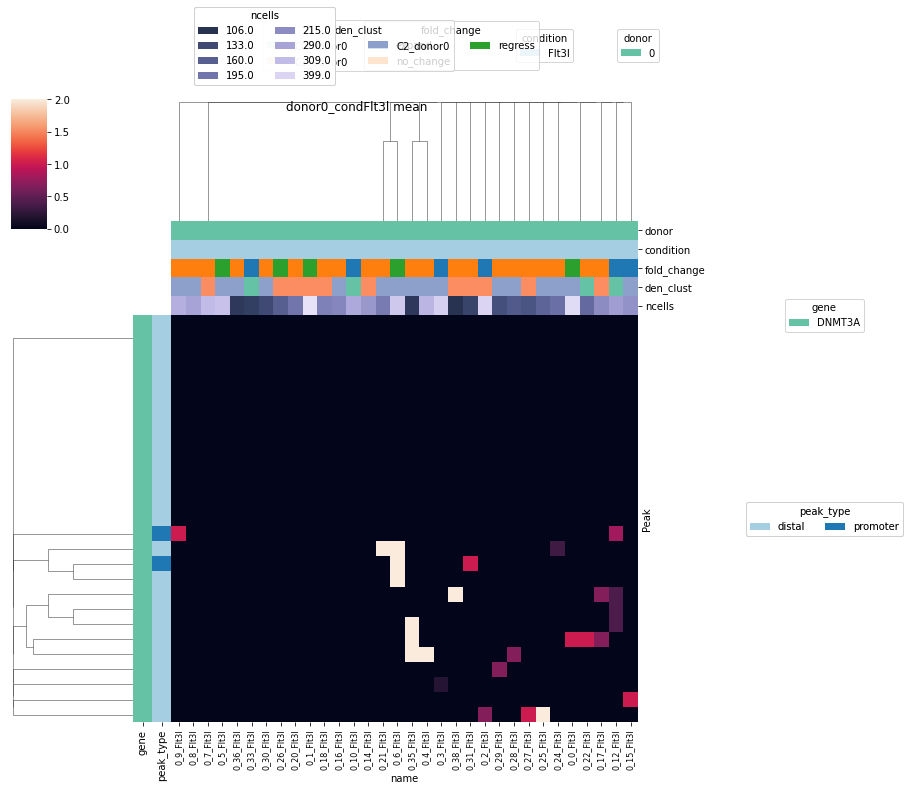

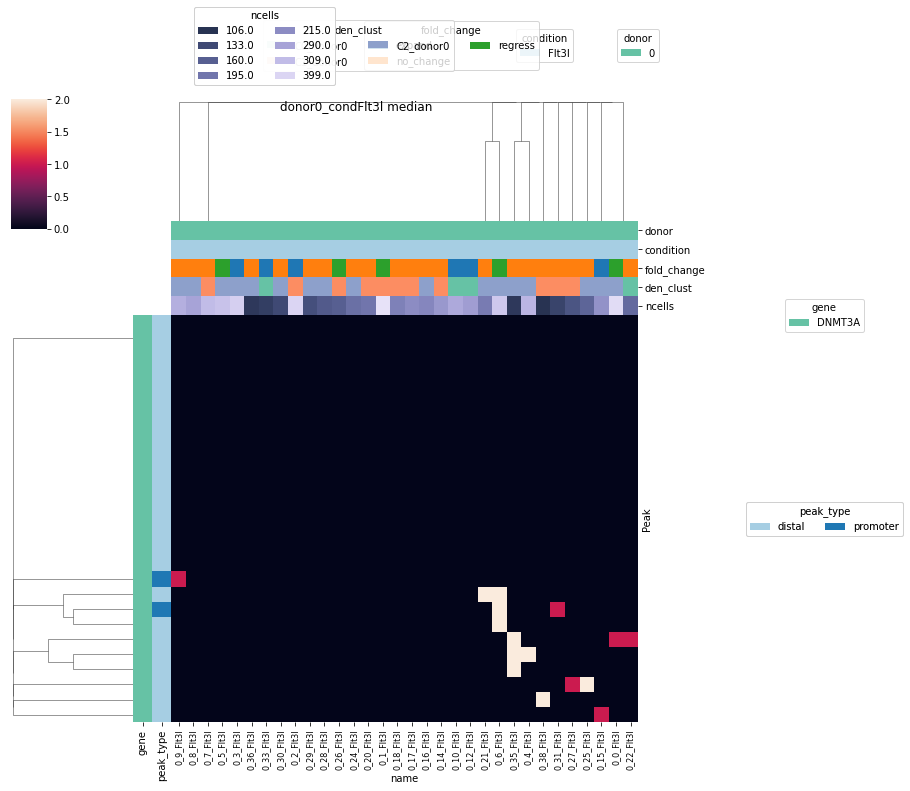

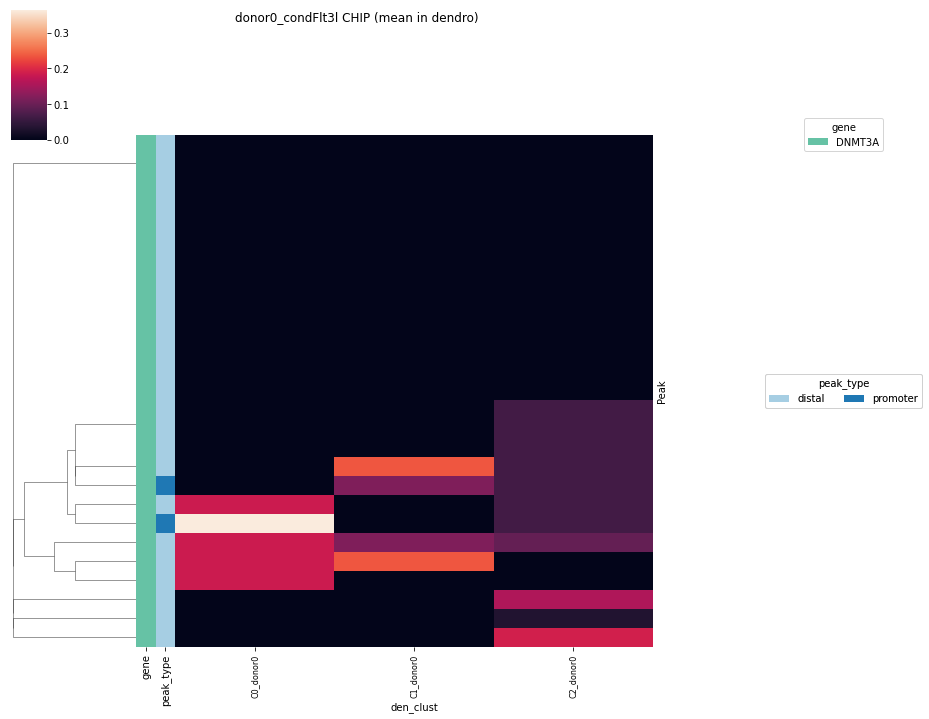

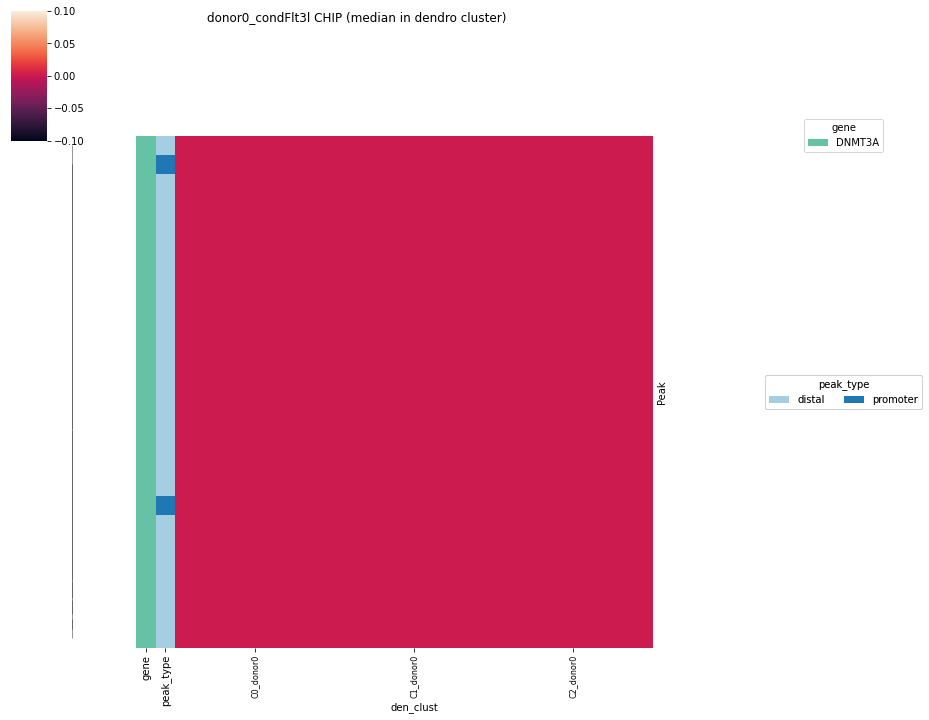

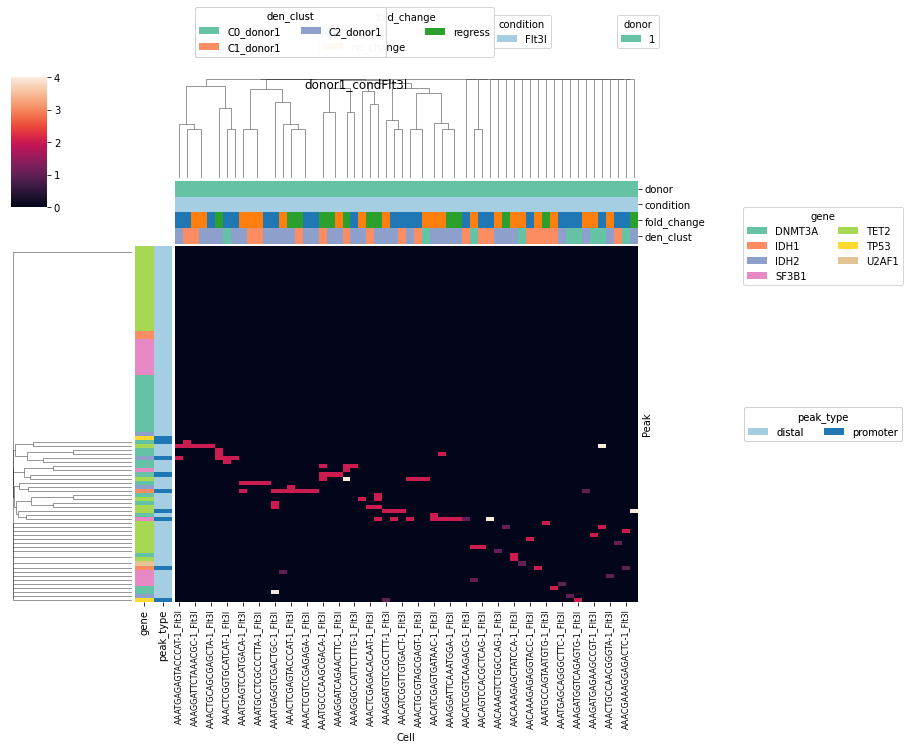

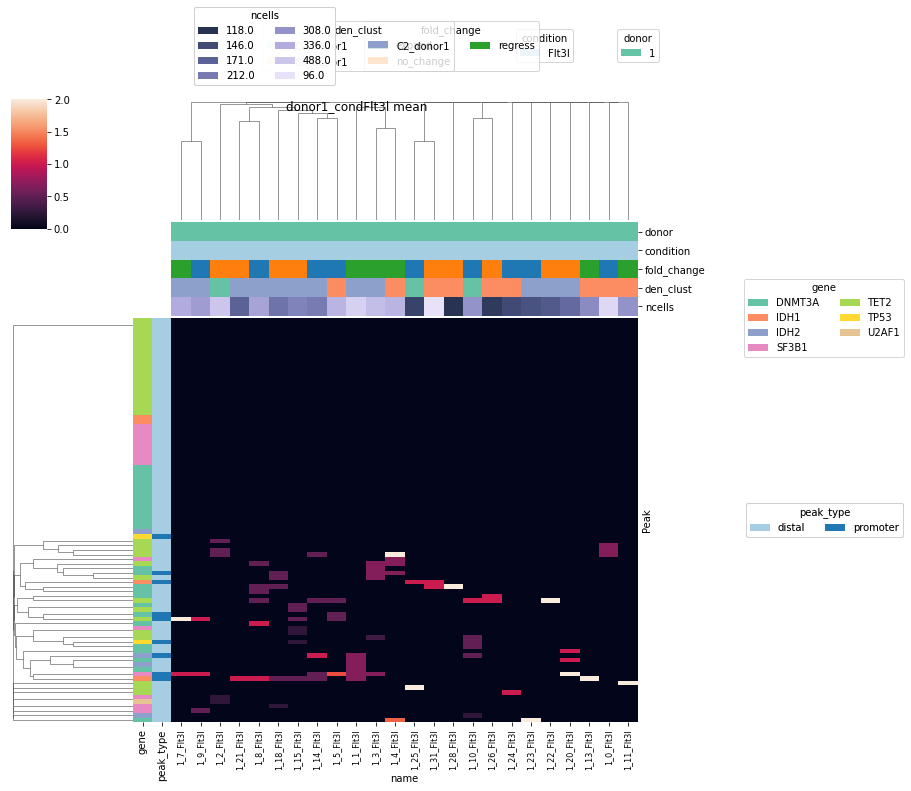

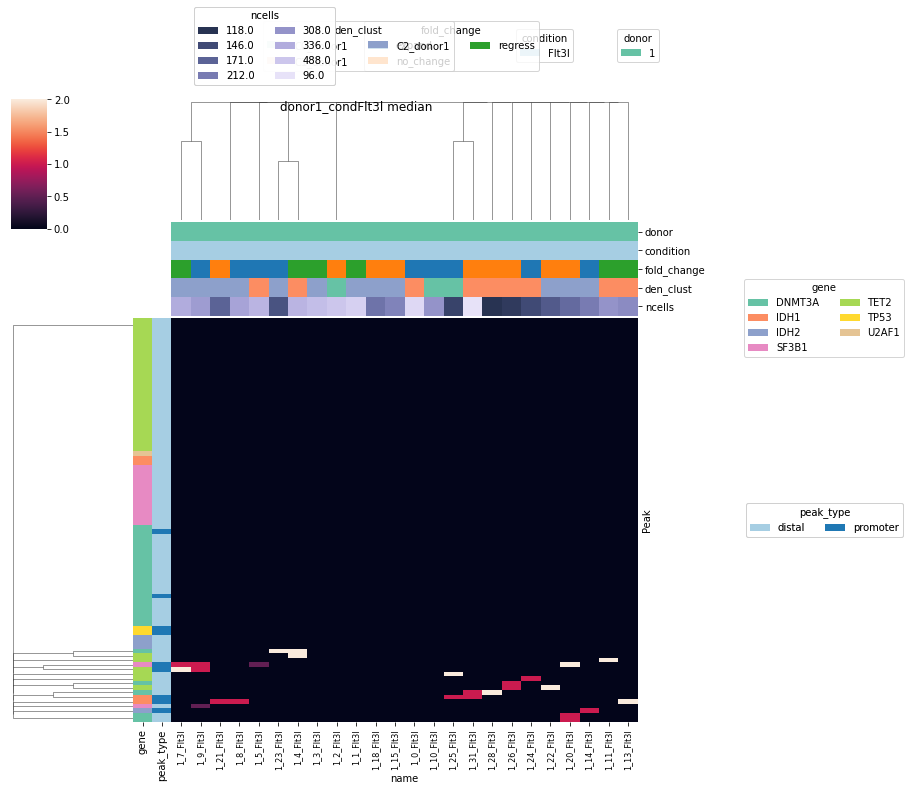

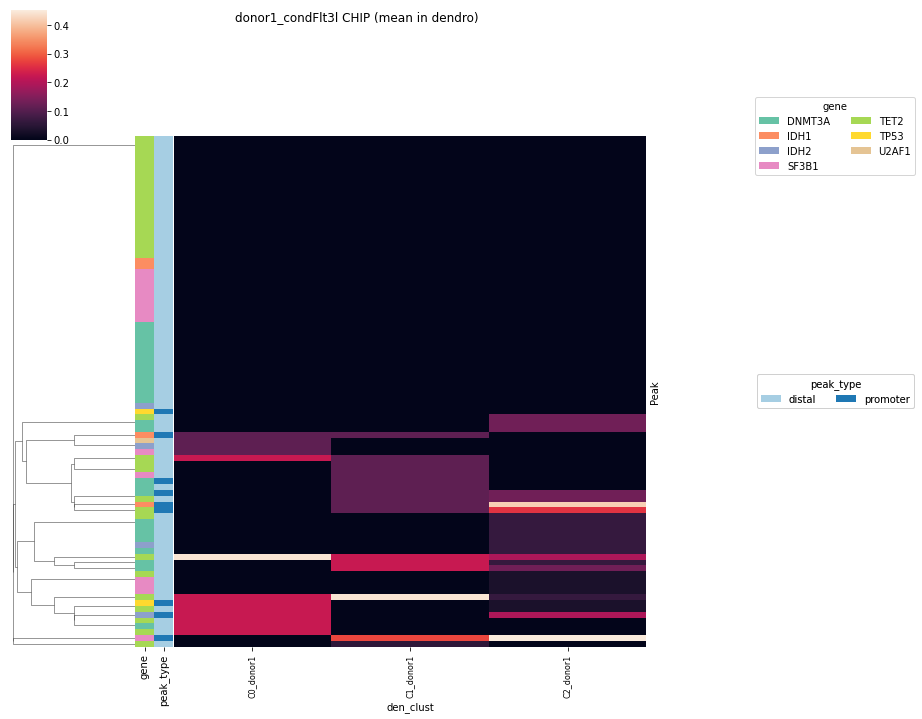

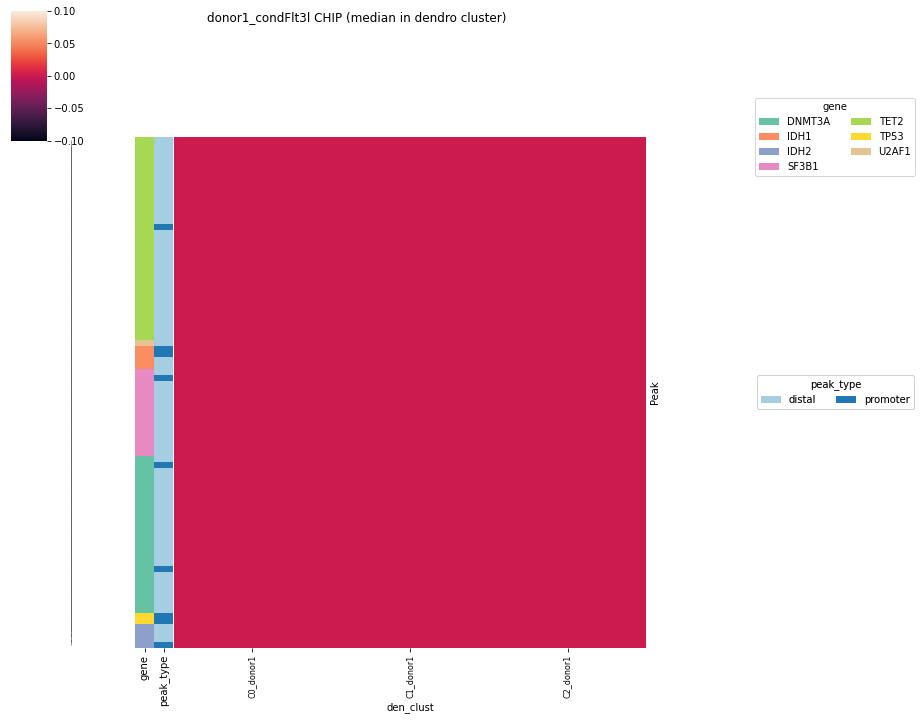

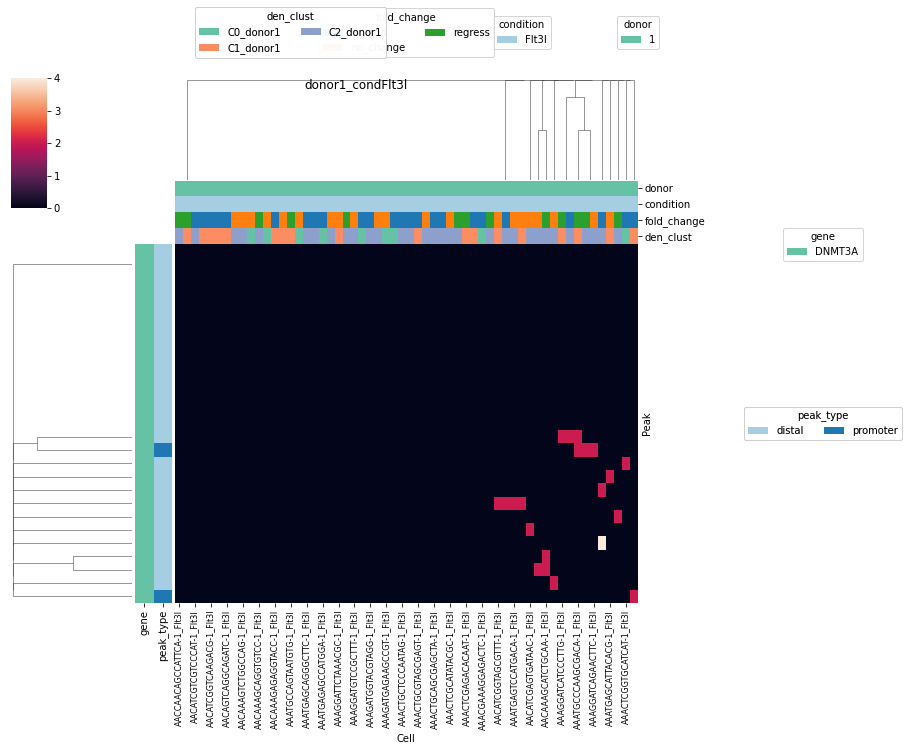

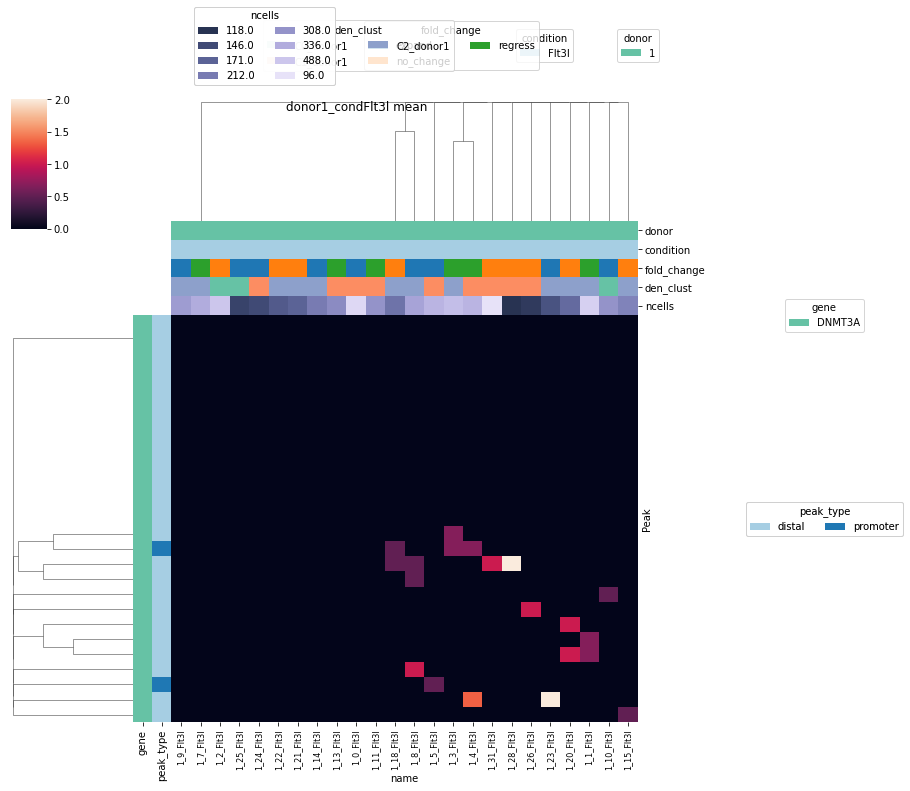

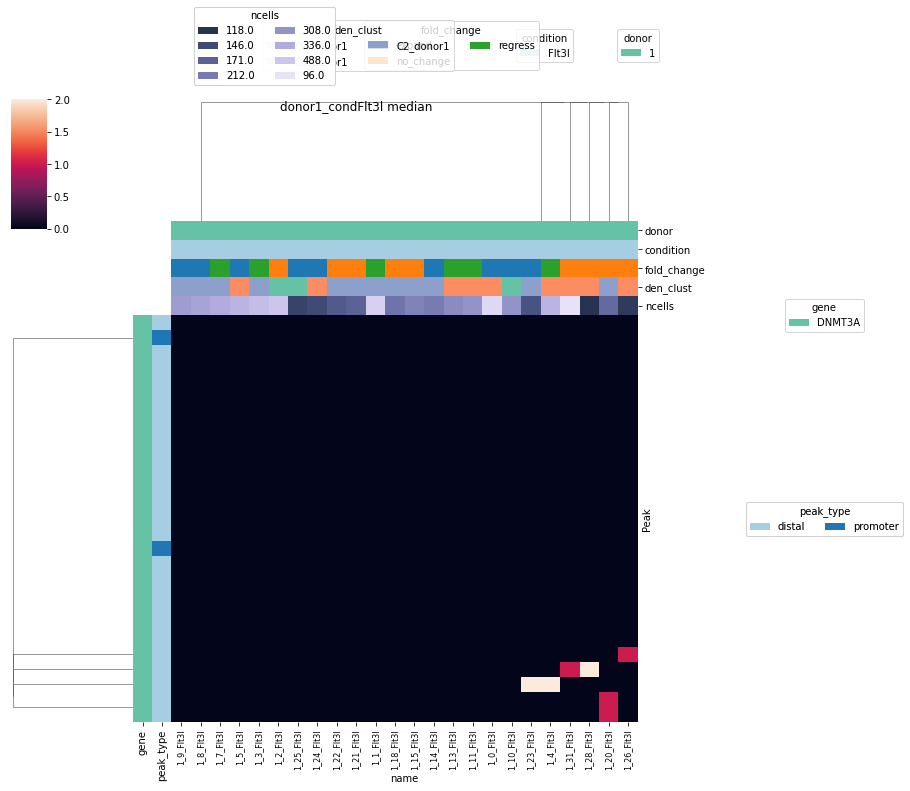

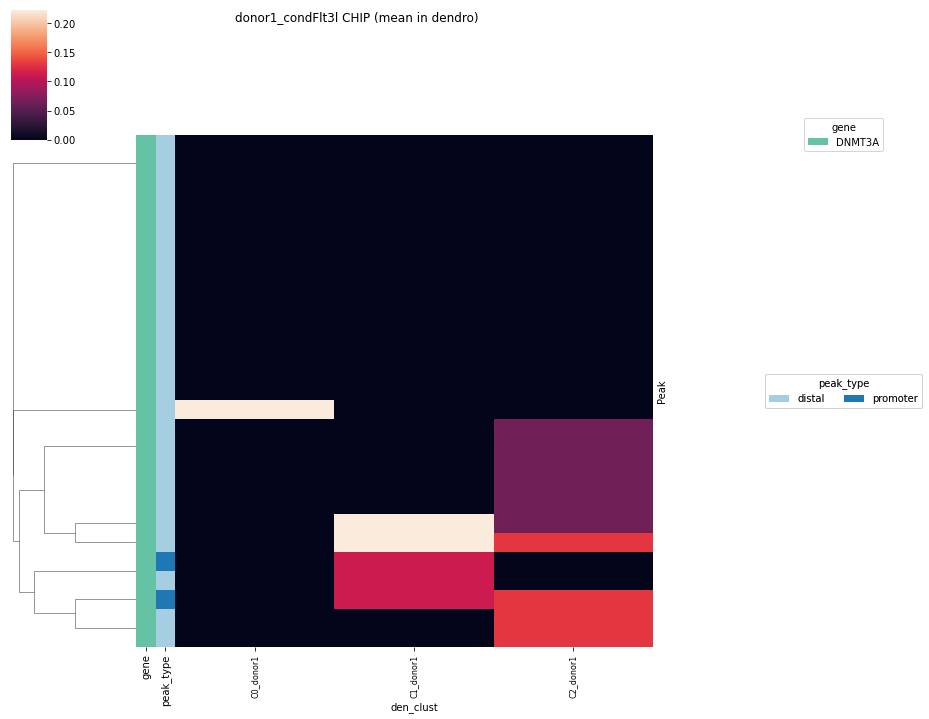

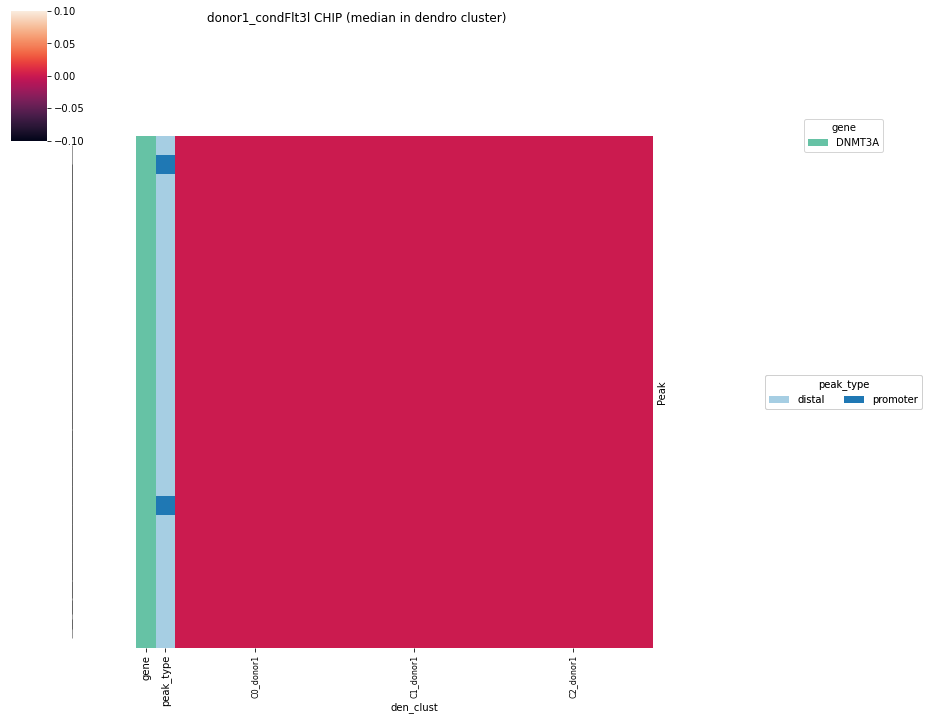

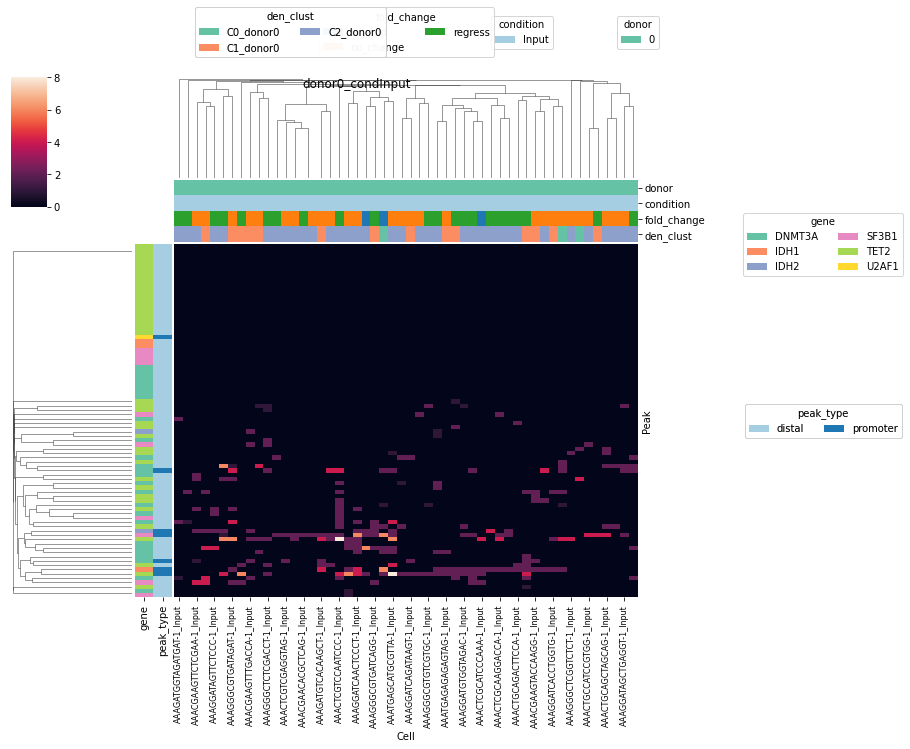

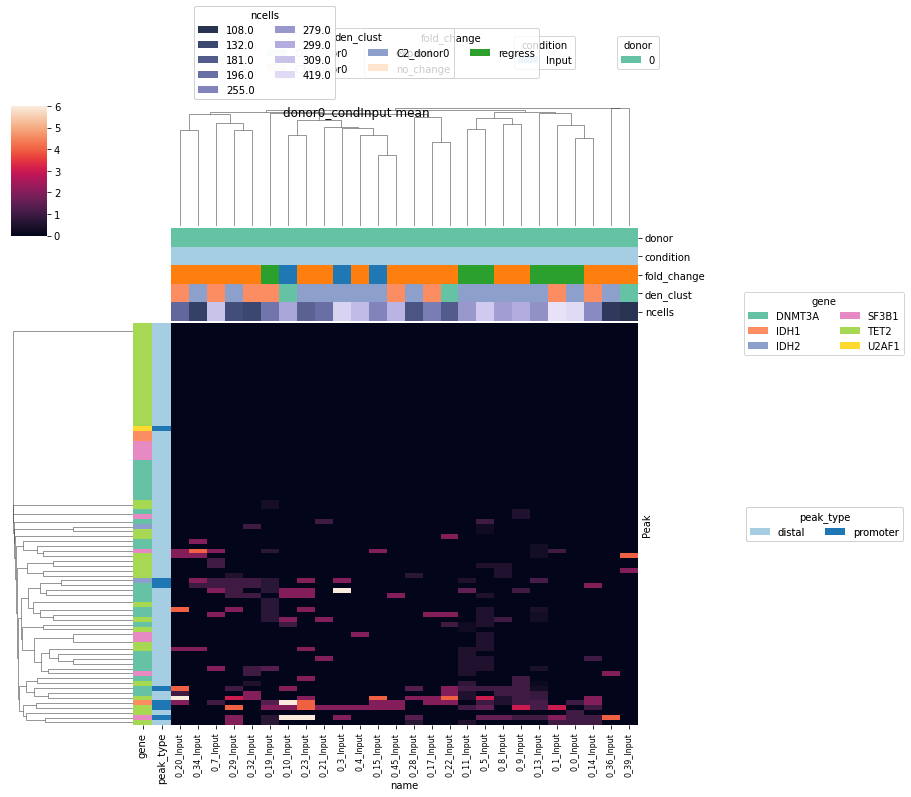

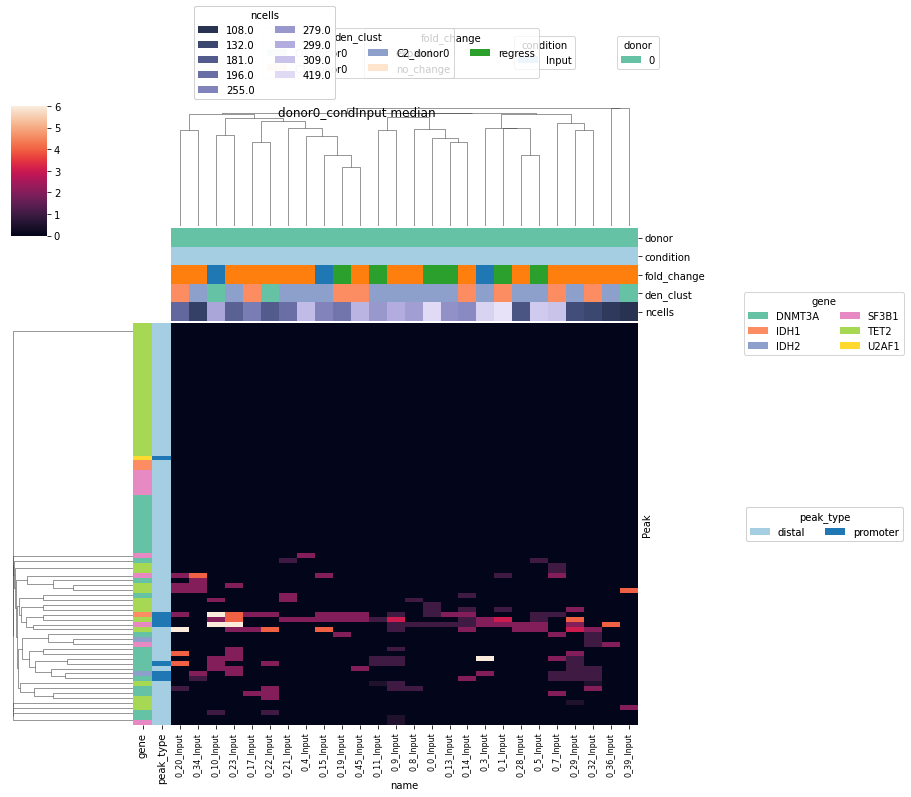

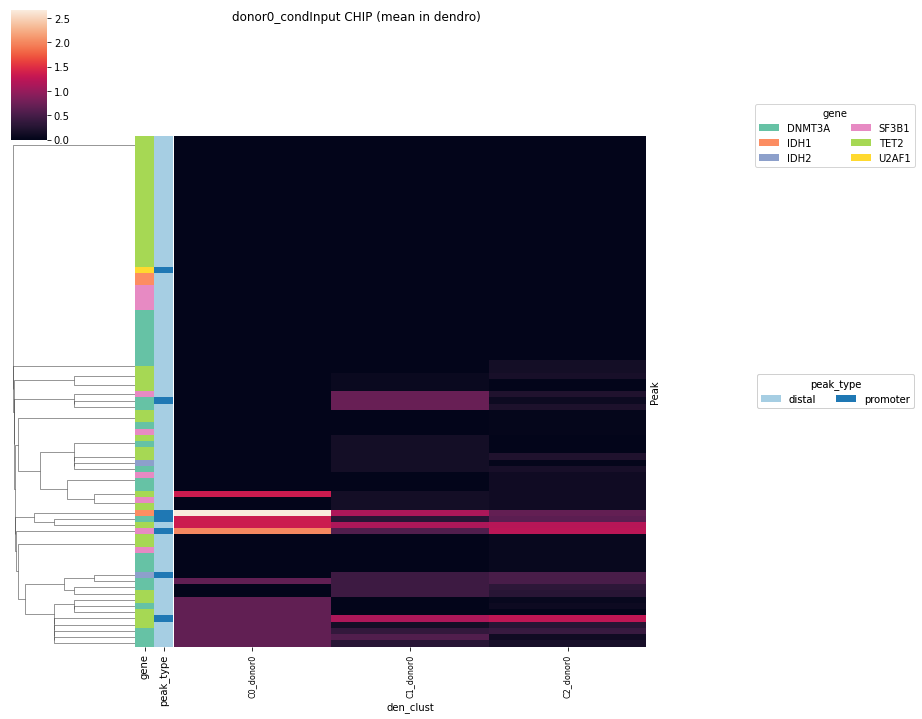

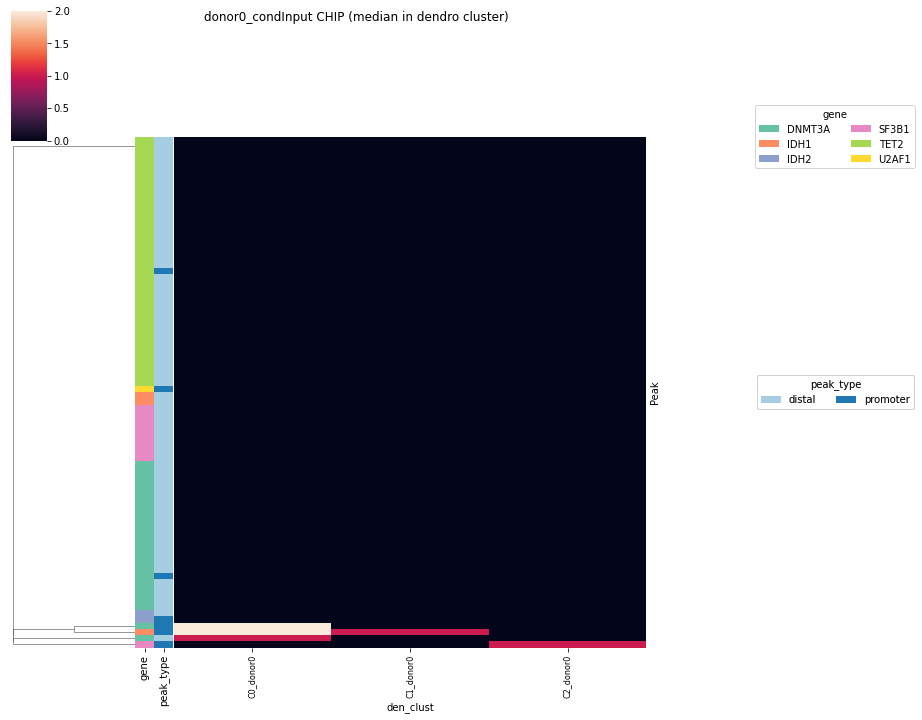

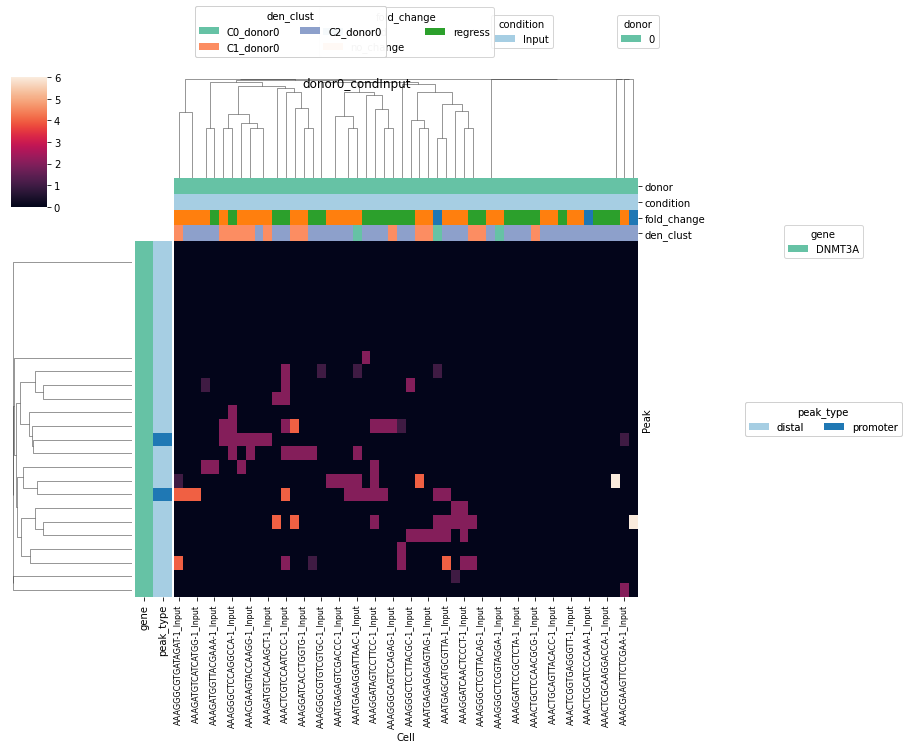

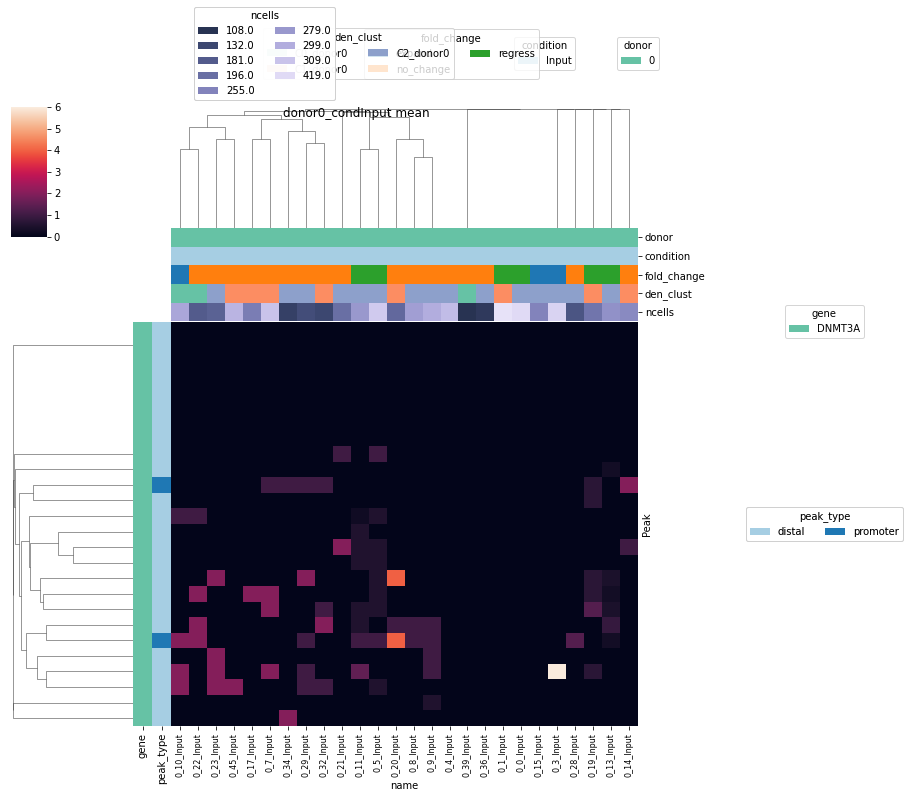

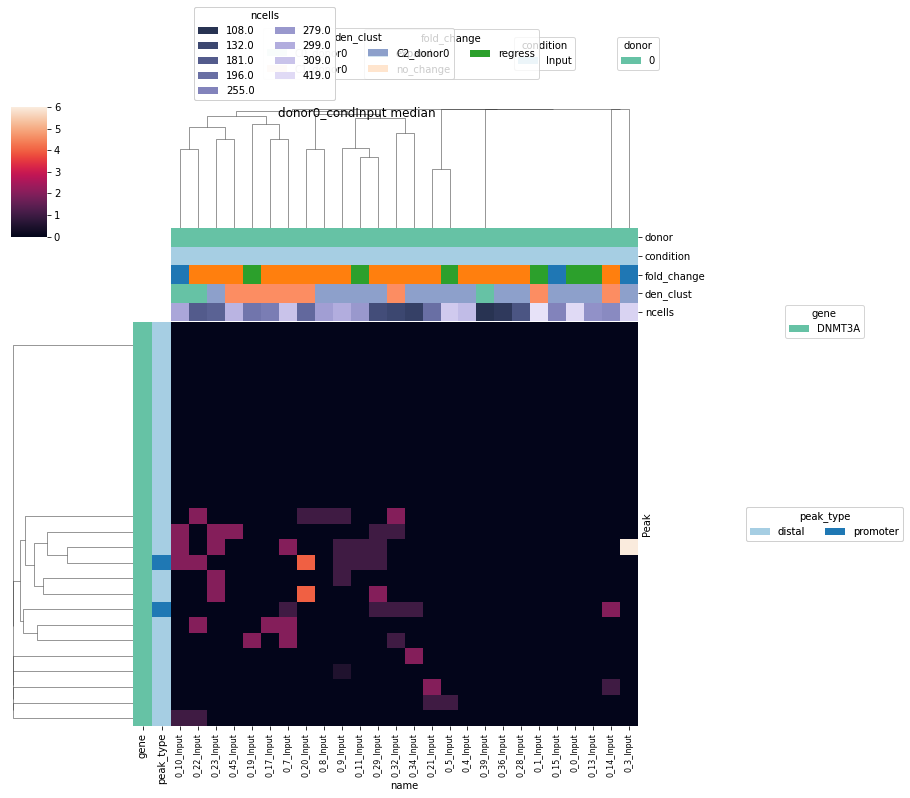

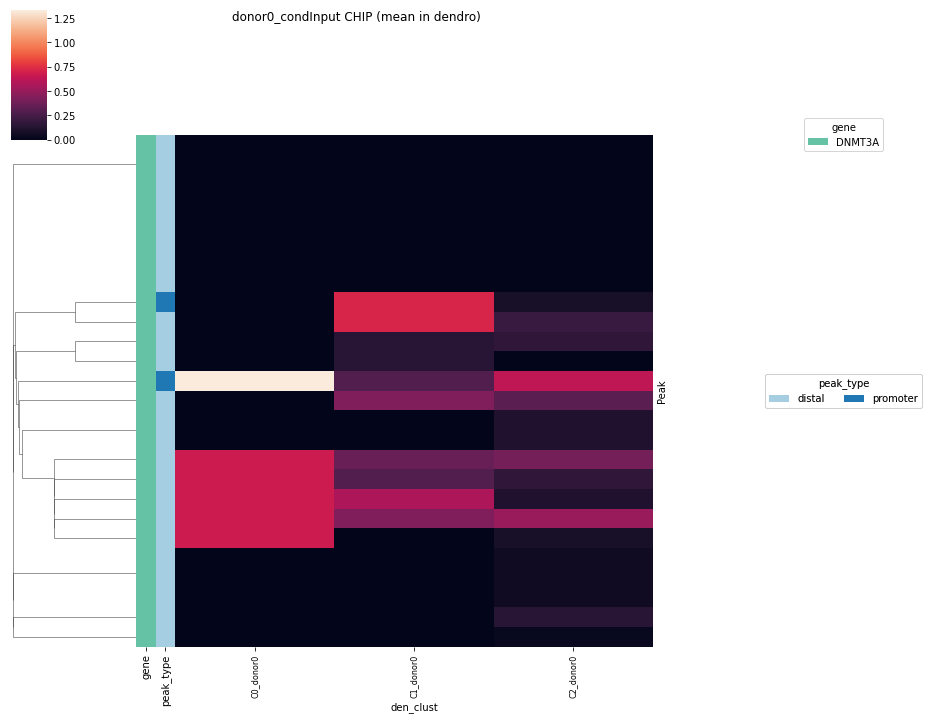

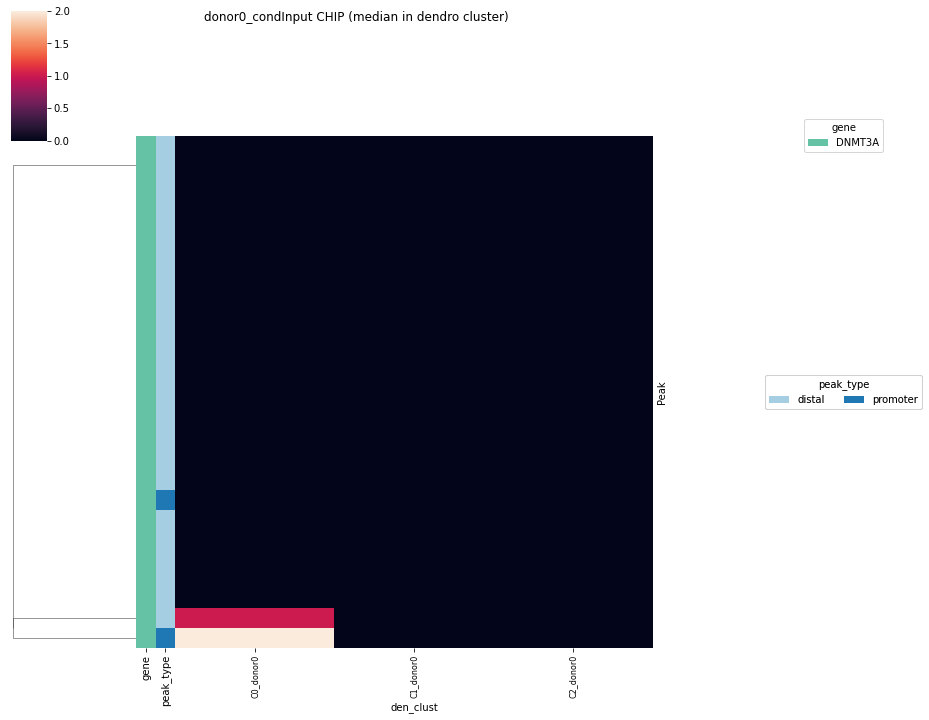

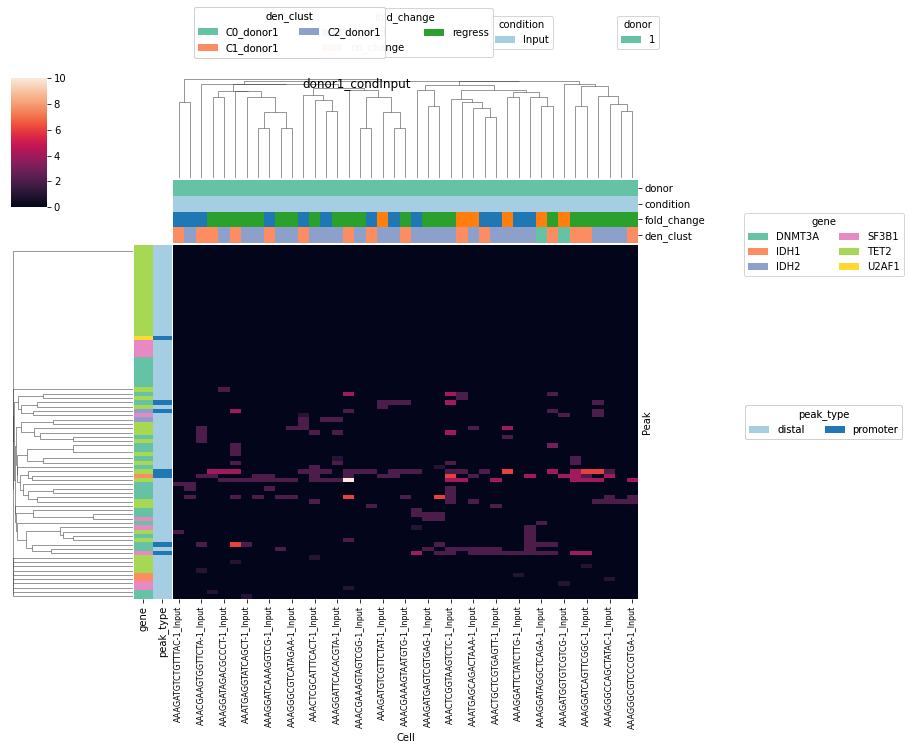

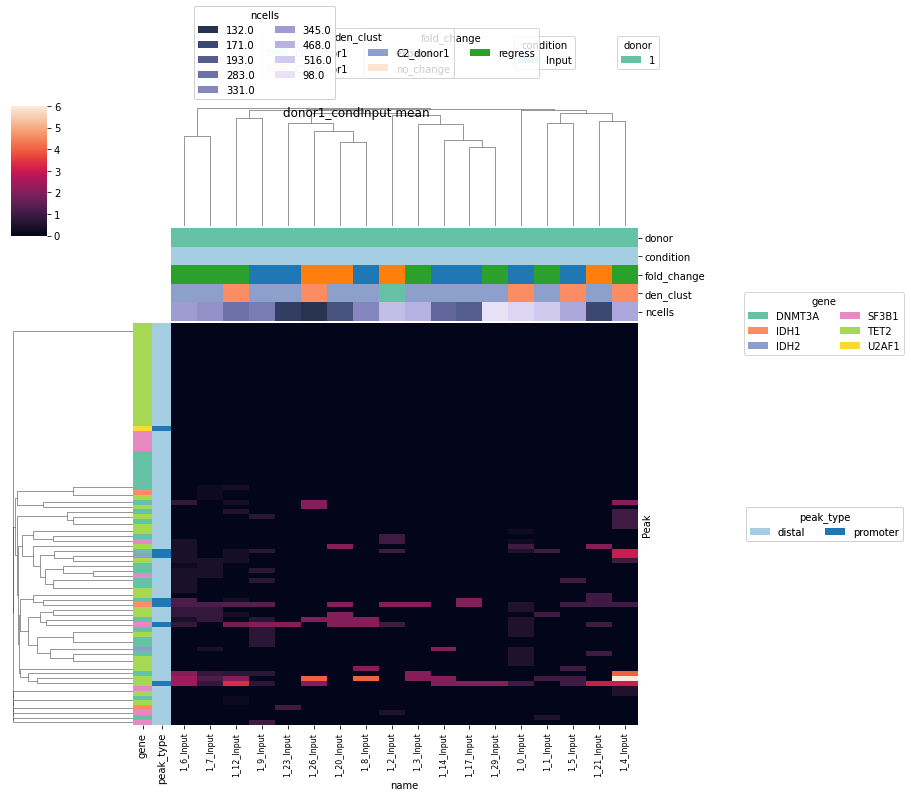

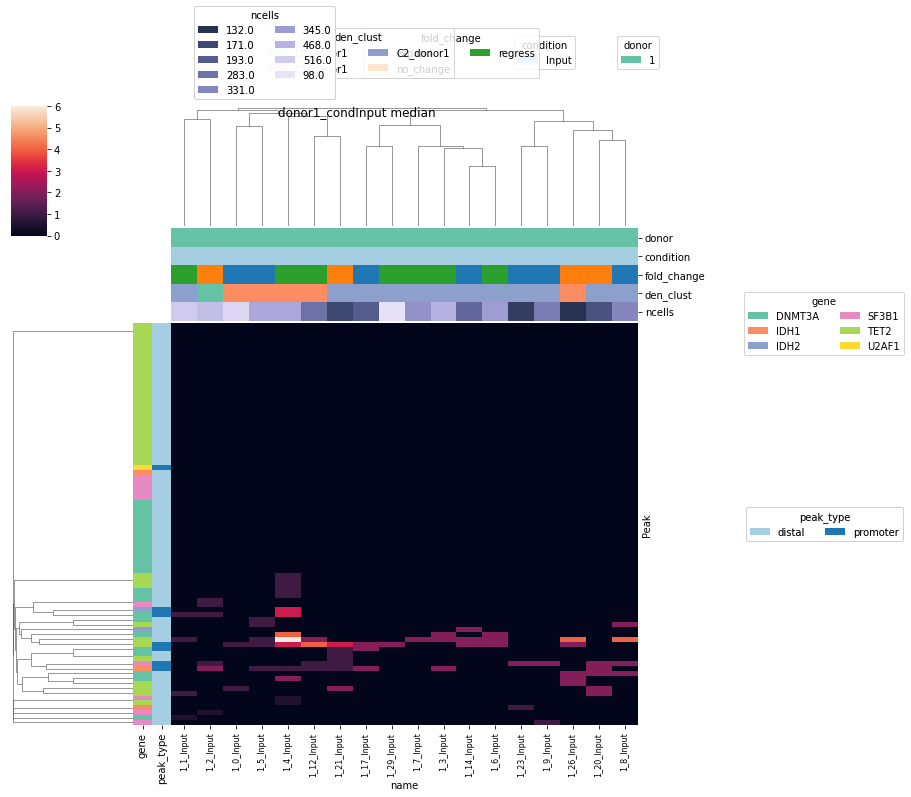

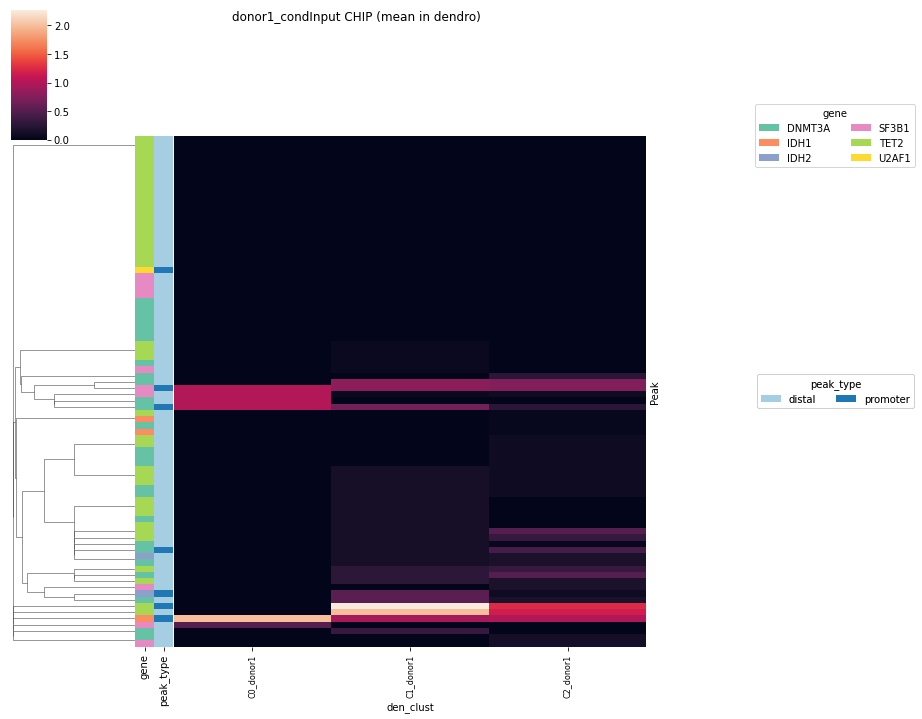

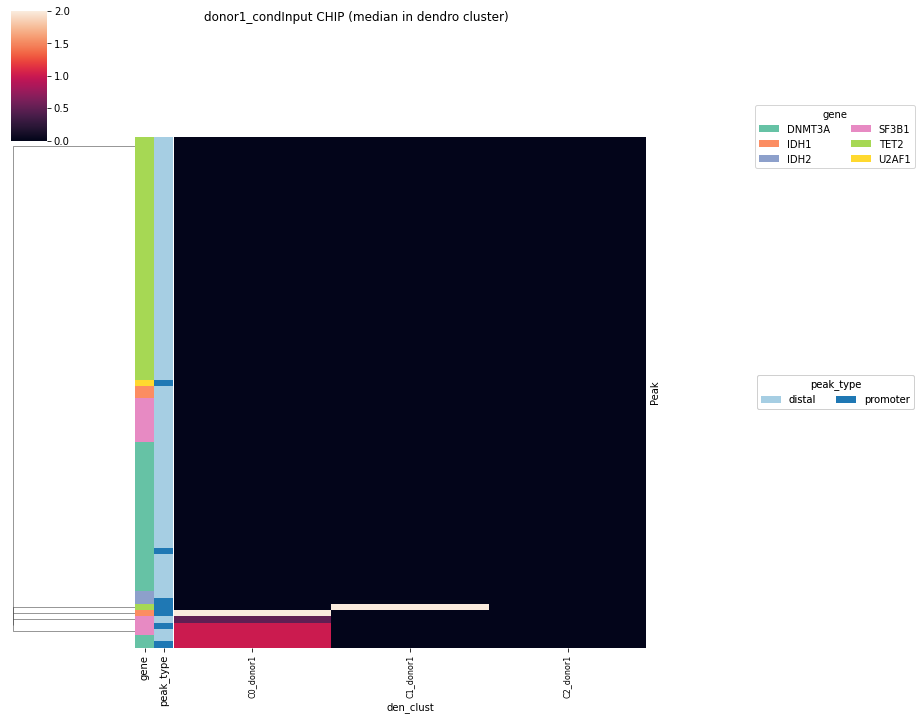

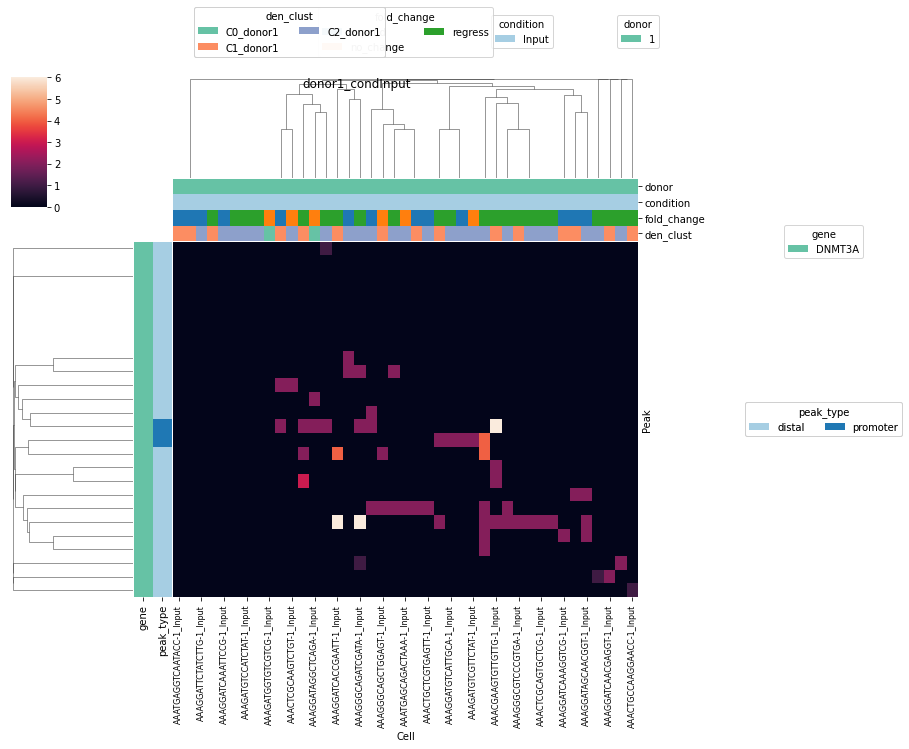

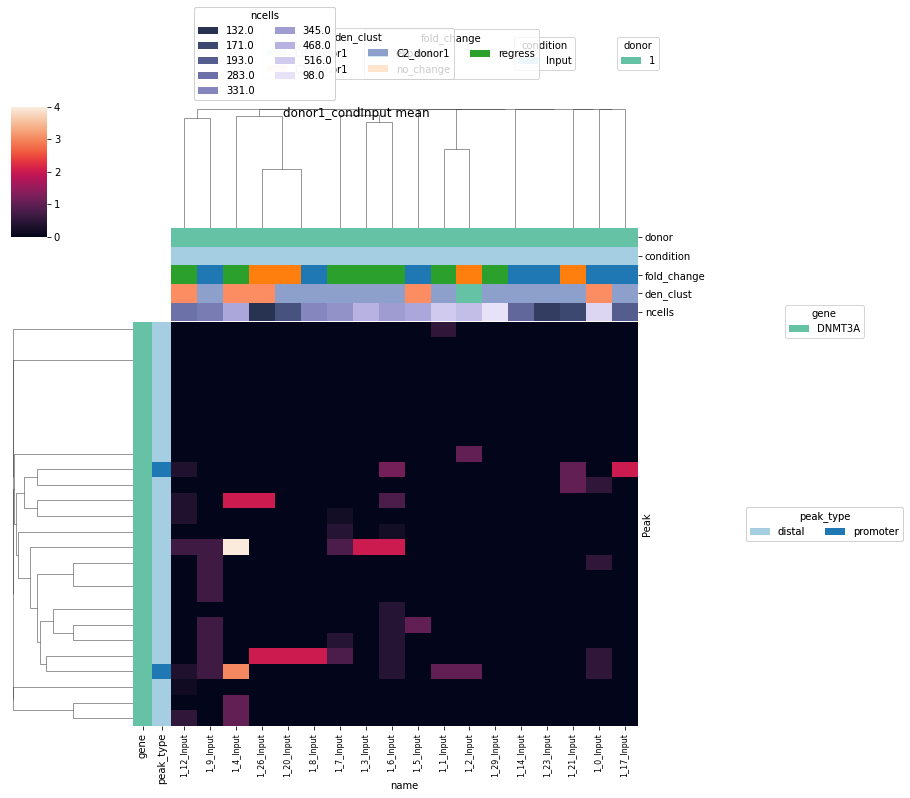

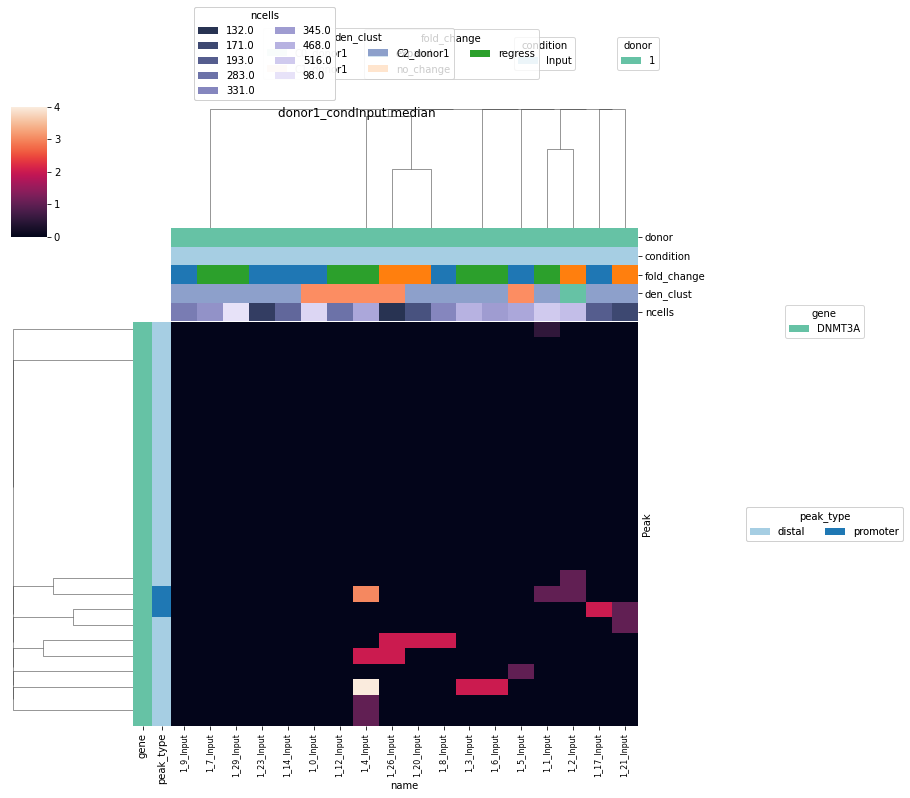

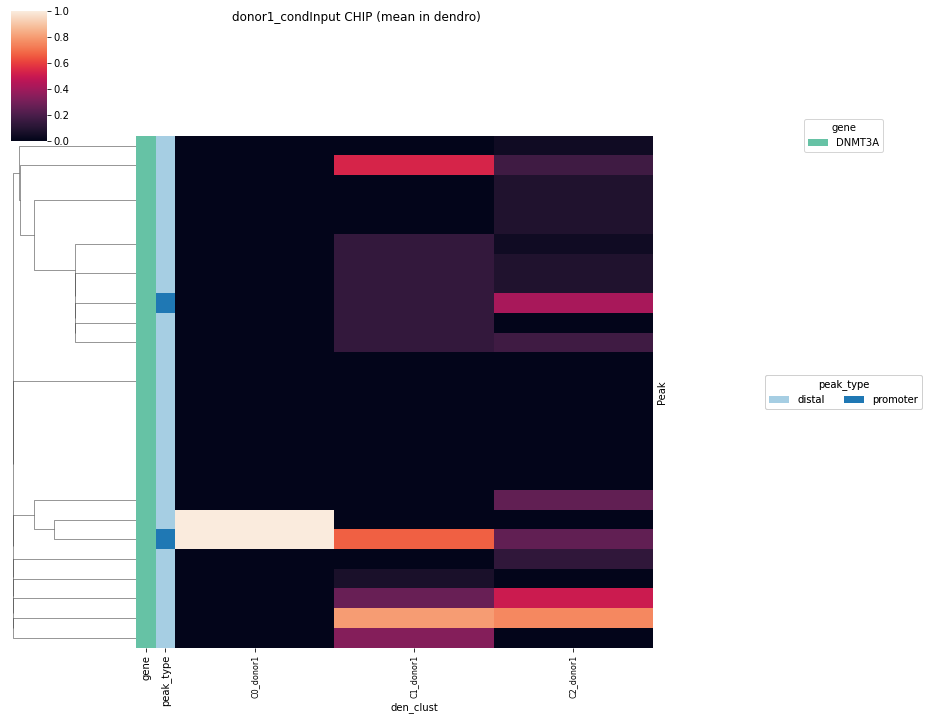

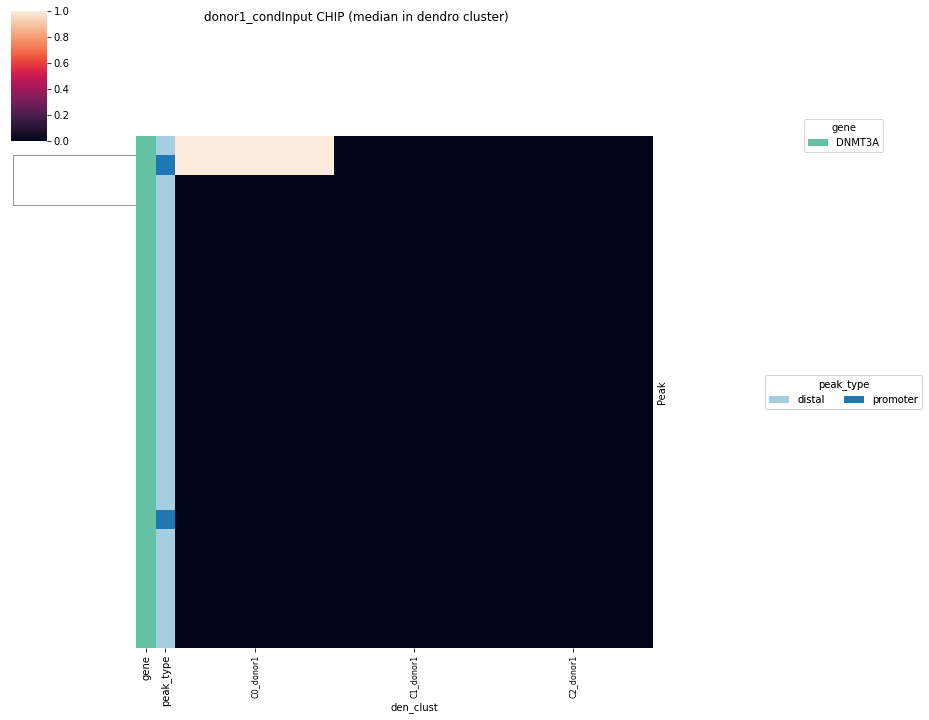

In [23]:
for s in samples:
    print(s)
    peaks_dense, CBs, chip_peaks_dense, chip_anno = process_frag_indir(frag_indir,s)
    # loop through donors
    for d in donors:
        curr_cells_meta = cells_meta[cells_meta["donor"]==d]     
    
        ## Plotting
        ###############################
        # CHIP peaks
        wrap_plots(chip_peaks_dense, chip_anno, curr_cells_meta, name=f"donor{d}_cond{s}", gene_name="CHIP", clones_meta=clones_meta)

        # DNMT3 peaks
        dnmt3a_peaks_dense, dnmt3a_anno = peaks_gene(chip_peaks_dense, "DNMT3A", chip_anno)
        wrap_plots(dnmt3a_peaks_dense, dnmt3a_anno, curr_cells_meta, name=f"donor{d}_cond{s}", gene_name="DNMT3A", clones_meta=clones_meta)


In [24]:
# #curr_in = join(config["indir"], config['CBs'][0], 'outs')
# for s in samples:
#     print(s)
#     curr_in = join(frag_indir, s, "outs")

#     CBs = pd.read_csv(join(frag_indir, single_cell_dirs[s], "outs", "singlecell.csv"))
#     CBs = CBs.loc[CBs["barcode"]!= "NO_BARCODE"].reset_index() ## drop the 'NO_BARCODE'
#     CBs.index= CBs.index+1
#     CBs["Condition ID"] = CBs["barcode"].apply(lambda x: x.split("-")[-1])
#     CBs["Condition"] = CBs["Condition ID"].astype(int).map(samples_dict)
      
#     cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)
#     ## Load peak annotations

#     peak_annotations = pd.read_csv(join(curr_in,'peak_annotation.tsv'),sep='\t')
#     peak_annotations.index=peak_annotations.index+1
#     peak_annotations["gene"] = peak_annotations["gene"].str.upper()
#     peak_annotations["Peak"]= peak_annotations.index
#     # peak_annotations

#     ## Filter for the chip genes 
#     ## Uses peak_annotations
#     # Load peaks matrix
#     filename = join(curr_in,'filtered_peak_bc_matrix/matrix.mtx')
#     peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=3, header=None)
#     peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]

#     chip_anno = peak_annotations[peak_annotations["gene"].isin(chip_genes)].set_index("Peak", drop=True).copy()
#     chip_anno.head()

#     peaks_sparse_mtx = peaks_sparse_mtx.loc[peaks_sparse_mtx["Peak"].isin(chip_anno.index)]
#     peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].map(peak_annotations["gene"])
#     CBs["barcode"] = CBs["barcode"] + "_" + s
#     peaks_sparse_mtx["Cell"] = peaks_sparse_mtx["Cell"].map(CBs['barcode'])
    
#     peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)
#     CBs = CBs.set_index("barcode")
#     chip_anno["ID"] = chip_anno.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
#     chip_peaks_dense = peaks_dense.loc[peaks_dense.index.isin(chip_anno.index)].copy()    

#     ###############################
#     ## Plotting
#     ###############################         
#     # 1. Cluster cells by peaks 
#     rand_df = chip_peaks_dense
#     #rand_df = chip_peaks_dense.sample(n=1000,axis=1)
#     rand_df, chip_cells_meta = filt_cells(rand_df, cells_meta) #cells_meta.loc[cells_meta.index.isin(dnmt3.columns)]
#     g = ch.plot_cluster(rand_df.fillna(0), row_meta=chip_anno.loc[rand_df.index,["gene", "peak_type"]], 
#                     col_meta=chip_cells_meta[["donor", "condition", "fold_change", "den_clust"]].astype(str),
#                     to_row_clust=True, 
#                     metric='jaccard', to_legend=True, white_name=None, row_names=False )
#     g.fig.suptitle(s)
#     plt.savefig(join(outdir, f"sample_{s}_CHIP_genes_chromatinFragments.png"), bbox_inches='tight')

    
#     ### Create clone meta for each condition

#     # 2. Get clone average
#     clones_peaks_dense = chip_cells_meta.groupby("name").apply(clone_mean, rand_df).fillna(0).transpose()
#     clones_peaks_dense.head()

#     clones_peaks_median_dense = chip_cells_meta.groupby("name").apply(clone_mean, rand_df, "median").fillna(0).transpose()
#     clones_peaks_median_dense.head()

#     # Convert the clone_condition to clone
#     curr_clone_meta = pd.DataFrame([get_clone(x, clones_meta) for x in clones_peaks_dense.columns])
#     curr_clone_meta.head()

#     col_clr_schemes = {c:"categorical" for c in ["donor", "condition", "fold_change", "den_clust"]}
#     col_clr_schemes["ncells"] = "sequential"

#     g = ch.plot_cluster(clones_peaks_dense.fillna(0), 
#                         row_meta=chip_anno.loc[clones_peaks_dense.index,["gene", "peak_type"]], 
#                         col_clr_schemes=col_clr_schemes,
#                         col_meta=curr_clone_meta[col_clr_schemes.keys()].astype(str),
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=True,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )

#     g.fig.suptitle(s+" mean")
#     plt.savefig(join(outdir, f"sample_{s}_cloneMean_chip_chromatinFragments.png"), bbox_inches='tight')
   
#     # 2b median of chip 
#     g = ch.plot_cluster(clones_peaks_median_dense.fillna(0), 
#                         row_meta=chip_anno.loc[clones_peaks_median_dense.index, ["gene", "peak_type"]], 
#                         col_clr_schemes=col_clr_schemes,
#                         col_meta=curr_clone_meta[col_clr_schemes.keys()].astype(str),
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=True,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )
#     g.fig.suptitle(s+" median")
#     plt.savefig(join(outdir, f"sample_{s}_cloneMedian_chip_chromatinFragments.png"), bbox_inches='tight')
   
#     # 3. Get dendro mean and median for chip   
#     dend_peaks_dense = chip_cells_meta.groupby("den_clust").apply(clone_mean, rand_df).fillna(0).transpose()
#     dend_peaks_median_dense = chip_cells_meta.groupby("den_clust").apply(clone_mean, rand_df, "median").fillna(0).transpose()

#     # 3a. mean
#     g = ch.plot_cluster(dend_peaks_dense.fillna(0), 
#                         row_meta=chip_anno.loc[dend_peaks_dense.index, ["gene", "peak_type"]], 
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=False,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )
  
#     g.fig.suptitle(s+" CHIP (mean in dendro)")
#     plt.savefig(join(outdir, f"sample_{s}_dendroMean_chip_chromatinFragments.png"), bbox_inches='tight')
    
#     # 3b. median
#     g = ch.plot_cluster(dend_peaks_median_dense.fillna(0), 
#                         row_meta=chip_anno.loc[dend_peaks_median_dense.index, ["gene", "peak_type"]], 
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=False,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )

#     g.fig.suptitle(s+" CHIP (median in dendro cluster)")
#     plt.savefig(join(outdir, f"sample_{s}_dendroMedian_chip_chromatinFragments.png"), bbox_inches='tight')

#     # DNMT3A-specific peaks

#     # 4. Run for DNMT3A gene
#     dnmt3, dnmt3_anno = peaks_gene(chip_peaks_dense, "DNMT3A", chip_anno)

#     curr_dnmt3, dnmt3_cells_meta = filt_cells(dnmt3, cells_meta) #cells_meta.loc[cells_meta.index.isin(dnmt3.columns)]
#     g = ch.plot_cluster(curr_dnmt3.fillna(0), row_meta=dnmt3_anno.loc[curr_dnmt3.index, ["gene", "peak_type"]], 
#                         col_meta=dnmt3_cells_meta[["donor", "condition", "fold_change", "den_clust"]].astype(str),
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=True,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )

#     g.fig.suptitle(s + " DNMT3A genes")
#     plt.savefig(join(outdir, f"sample_{s}_dnmt3a_chromatinFragments.png"), bbox_inches='tight')

#     ### Create clone meta for each condition
#     # 5. Get clone average
#     clones_peaks_dense = dnmt3_cells_meta.groupby("name").apply(clone_mean, dnmt3).fillna(0).transpose()
#     clones_peaks_dense.head()

#     clones_peaks_median_dense = dnmt3_cells_meta.groupby("name").apply(clone_mean, dnmt3, "median").fillna(0).transpose()
#     clones_peaks_median_dense.head()

#     # Convert the clone_condition to clone
#     curr_clone_meta = pd.DataFrame([get_clone(x, clones_meta) for x in clones_peaks_dense.columns])
#     curr_clone_meta.head()

#     g = ch.plot_cluster(clones_peaks_dense.fillna(0), 
#                         row_meta=dnmt3_anno.loc[clones_peaks_dense.index, ["gene", "peak_type"]], col_clr_schemes=col_clr_schemes,
#                         col_meta=curr_clone_meta[col_clr_schemes.keys()].astype(str),
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=True,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )

#     g.fig.suptitle(s+" DNMT3A")
#     plt.savefig(join(outdir, f"sample_{s}_cloneMean_dnmt3a_chromatinFragments.png"), bbox_inches='tight')

#     # 5b median of dnmt3
#     g = ch.plot_cluster(clones_peaks_median_dense.fillna(0), 
#                         row_meta=dnmt3_anno.loc[clones_peaks_median_dense.index, ["gene", "peak_type"]], 
#                         col_meta=curr_clone_meta[col_clr_schemes.keys()].astype(str),
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=True, col_clr_schemes=col_clr_schemes,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )

#     g.fig.suptitle(s+" DNMT3A")
#     plt.savefig(join(outdir, f"sample_{s}_cloneMedian_dnmt3a_chromatinFragments.png"), bbox_inches='tight')


#     # 6. Get dendro mean and median for dnmt3
#     clones_peaks_dense = dnmt3_cells_meta.groupby("den_clust").apply(clone_mean, dnmt3).fillna(0).transpose()
#     clones_peaks_dense.head()

#     clones_peaks_median_dense = dnmt3_cells_meta.groupby("den_clust").apply(clone_mean, dnmt3, "median").fillna(0).transpose()
#     clones_peaks_median_dense.head()

#     # Convert the clone_condition to clone
#     dendro_donor = {c:clones_meta.loc[clones_meta["den_clust"]==c, "donor"].values[0] for c in clones_peaks_dense.columns}
#     curr_clone_meta = pd.DataFrame(dendro_donor, index=["donor"]).transpose()

#     g = ch.plot_cluster(clones_peaks_dense.fillna(0), 
#                         row_meta=dnmt3_anno.loc[clones_peaks_dense.index, ["gene", "peak_type"]], 
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=True,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )

#     g.fig.suptitle(s+" DNMT3A (mean in dendro)")
#     plt.savefig(join(outdir, f"sample_{s}_dendroMean_dnmt3a_chromatinFragments.png"), bbox_inches='tight')

#     # Median
#     g = ch.plot_cluster(clones_peaks_median_dense.fillna(0), 
#                         row_meta=dnmt3_anno.loc[clones_peaks_median_dense.index, ["gene", "peak_type"]], 
#                         to_row_clust=True, sep_clr_map=True, to_col_clust=True,
#                         metric='jaccard', to_legend=True, white_name=None, row_names=False )

#     g.fig.suptitle(s+" DNMT3A (median in dendro cluster)")
#     plt.savefig(join(outdir, f"sample_{s}_dendroMedian_dnmt3a_chromatinFragments.png"), bbox_inches='tight')
    
#     break
